### Import Package

In [1]:
# Import packages
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import datetime
from datetime import datetime, timedelta
from shapely.geometry import Point, shape, LineString
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler
import libpysal as ps
from spreg import GM_Lag
from sklearn.linear_model import LassoCV
import statsmodels.api as sm
import os
from zipfile import ZipFile
import random
import networkx as nx
import warnings

- Aggregated station group prediction 
- Single station level prediction
- Single station level prediction with station type classification (GMM based on GA or usage similarity)
- how to model spatial relationships between stations (based on GA, LU, and others, or self-learning and try to understand the learning results based on what)

### Read file and data preprocess

#### Select station within DC boundary

In [2]:
# read station information
station_info = pd.read_csv('Data/station_info.csv')
station_info['geometry'] = station_info[['longitude', 'latitude']].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)

# select those bike stations within DC 
DC_road_info = gpd.read_file('Data/Shapefile/Roads.geojson')
DC_boundary = gpd.read_file('Data/Shapefile/Washington_DC_Boundary.geojson')
DC_station_index = []
for i in range (len(station_info)):
    if station_info.geometry[i].within(DC_boundary.geometry[0]):
        DC_station_index.append(i)
station_info = station_info.loc[DC_station_index].reset_index()
station_info.head()

,index,station_id,latitude,longitude,geometry
0,98,31100.0,38.900289,-77.042902,POINT (-77.04290151498334 38.900288516366665)
1,99,31101.0,38.917766,-77.032083,POINT (-77.0320827701709 38.91776604521078)
2,100,31102.0,38.929463,-77.027821,POINT (-77.02782140873842 38.92946313339121)
3,101,31104.0,38.922865,-77.042517,POINT (-77.04251684149087 38.92286480915612)
4,102,31105.0,38.926792,-77.032203,POINT (-77.0322025645055 38.92679209829671)


#### Read bike-sharing trip data

In [3]:
# read bikeshare data in 2020.03 for single csv file
# sharingbikedata = pd.read_csv('Data/202003-capitalbikeshare-tripdata.csv')
# sharingbikedata = sharingbikedata[sharingbikedata['Start station number'].isin(station_info.station_id.unique())]
# sharingbikedata = sharingbikedata[sharingbikedata['End station number'].isin(station_info.station_id.unique())]

# read bikeshare data from zip files

# Open the zip file in read-only mode.
warnings.filterwarnings('ignore')

directory = "Data/bike_trip_data/"
file_paths = []
# crawling through directory and subdirectories
for root, directories, files in os.walk(directory):
    for filename in files:
        # join the two strings in order to form the full filepath.
        filepath = os.path.join(root, filename)
        file_paths.append(filepath)

sharingbikedata = []
for i in range (len(file_paths)):
    archive = ZipFile(file_paths[i], "r")
    bike_trips = pd.read_csv(archive.open(archive.namelist()[0]))
    sharingbikedata.append(bike_trips)
sharingbikedata = pd.concat(sharingbikedata, axis=0)
sharingbikedata.reset_index(drop=True, inplace=True)
print(len(sharingbikedata))
sharingbikedata = sharingbikedata[sharingbikedata['Start station number'].isin(station_info.station_id.unique())]
sharingbikedata = sharingbikedata[sharingbikedata['End station number'].isin(station_info.station_id.unique())]
sharingbikedata.head()

3398417


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,230,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,14th & Rhode Island Ave NW,31200,Massachusetts Ave & Dupont Circle NW,E00141,Member
1,1549,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,15th St & Constitution Ave NW,31114,18th St & Wyoming Ave NW,W24067,Casual
2,177,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,Adams Mill & Columbia Rd NW,31323,Woodley Park Metro / Calvert St & Connecticut ...,W22654,Casual
3,228,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,8th & O St NW,31280,11th & S St NW,W22336,Member
5,1202,2019-01-01 00:12:50,2019-01-01 00:32:53,31618,4th & East Capitol St NE,31269,3rd St & Pennsylvania Ave SE,W20775,Member


#### Data merge with lat & lon info

In [4]:
# add station name into station info
station_info_name = station_info.merge(sharingbikedata[['Start station number', 'Start station']].drop_duplicates(),
                                       how = "left",
                                       left_on = "station_id",
                                       right_on = "Start station number")
station_info_name = station_info_name.drop(columns = "Start station number")
station_info_name = station_info_name.rename(columns = {'Start station': 'station_name'})

# add start_station_info into sharingbikedata
sharingbikedata = sharingbikedata.merge(station_info,
                                        how = 'left',
                                        left_on = 'Start station number',
                                        right_on = 'station_id')
sharingbikedata = sharingbikedata.rename(columns = {"latitude": "start_lat",
                                                   "longitude": "start_lon",
                                                   "geometry": "start_geo"})

# add end_station_info into sharingbikedata
sharingbikedata = sharingbikedata.merge(station_info,
                                        how = 'left',
                                        left_on = 'End station number',
                                        right_on = 'station_id')
sharingbikedata = sharingbikedata.rename(columns = {"latitude": "end_lat",
                                                   "longitude": "end_lon",
                                                   "geometry": "end_geo"})


sharingbikedata = sharingbikedata.drop(columns = {"station_id_x", "station_id_y", "index_x", "index_y", "Member type", "Start station", "End station"}, axis = 1)
sharingbikedata.head()

,Duration,Start date,End date,Start station number,End station number,Bike number,start_lat,start_lon,start_geo,end_lat,end_lon,end_geo
0,230,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,E00141,38.908598,-77.032304,POINT (-77.03230426292606 38.90859789247971),38.910103,-77.044394,POINT (-77.04439437680891 38.91010276338776)
1,1549,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,W24067,38.892245,-77.033233,POINT (-77.03323264662363 38.89224468680707),38.918805,-77.041569,POINT (-77.0415693340696 38.91880522982117)
2,177,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,W22654,38.922865,-77.042517,POINT (-77.04251684149087 38.92286480915612),38.923392,-77.051830,POINT (-77.05183042603885 38.92339171298058)
3,228,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,W22336,38.908637,-77.022776,POINT (-77.02277550199454 38.90863746501813),38.913756,-77.027032,POINT (-77.02703157099604 38.913756459944665)
4,1202,2019-01-01 00:12:50,2019-01-01 00:32:53,31618,31269,W20775,38.889955,-77.000351,POINT (-77.000351044744 38.889955161619646),38.887375,-77.001957,POINT (-77.00195738745647 38.88737544448145)


#### Travel duration & distance

In [5]:
# compute travel time (min)
sharingbikedata['Duration'] = sharingbikedata['Duration']/60
sharingbikedata = sharingbikedata.rename(columns = {'Duration': 'Trip Duration in Minutes'})

# compute travel distance (mile)
origin_geo = gpd.GeoDataFrame({'geometry': sharingbikedata.start_geo}, crs='EPSG:4326').to_crs('EPSG:5234')
destination_geo = gpd.GeoDataFrame({'geometry': sharingbikedata.end_geo}, crs='EPSG:4326').to_crs('EPSG:5234')
sharingbikedata['Geometric Distance in Miles'] = origin_geo.distance(destination_geo) * 0.000621371

sharingbikedata.head()

,Trip Duration in Minutes,Start date,End date,Start station number,End station number,Bike number,start_lat,start_lon,start_geo,end_lat,end_lon,end_geo,Geometric Distance in Miles
0,3.833333,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,E00141,38.908598,-77.032304,POINT (-77.03230426292606 38.90859789247971),38.910103,-77.044394,POINT (-77.04439437680891 38.91010276338776),0.690227
1,25.816667,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,W24067,38.892245,-77.033233,POINT (-77.03323264662363 38.89224468680707),38.918805,-77.041569,POINT (-77.0415693340696 38.91880522982117),1.973404
2,2.950000,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,W22654,38.922865,-77.042517,POINT (-77.04251684149087 38.92286480915612),38.923392,-77.051830,POINT (-77.05183042603885 38.92339171298058),0.526338
3,3.800000,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,W22336,38.908637,-77.022776,POINT (-77.02277550199454 38.90863746501813),38.913756,-77.027032,POINT (-77.02703157099604 38.913756459944665),0.440499
4,20.033333,2019-01-01 00:12:50,2019-01-01 00:32:53,31618,31269,W20775,38.889955,-77.000351,POINT (-77.000351044744 38.889955161619646),38.887375,-77.001957,POINT (-77.00195738745647 38.88737544448145),0.207060


In [6]:
sharingbikedata[["Trip Duration in Minutes", "Geometric Distance in Miles"]].describe()

,Trip Duration in Minutes,Geometric Distance in Miles
count,2.874732e+06,2.874732e+06
mean,1.751354e+01,1.117099e+00
std,3.599026e+01,7.353600e-01
min,1.000000e+00,0.000000e+00
25%,6.683333e+00,5.895528e-01
50%,1.128333e+01,9.642786e-01
75%,1.873333e+01,1.502387e+00
max,1.439417e+03,1.127346e+01


#### Add temporal variables (hour and day)

In [7]:
## add hour and day
sharingbikedata['Start date'] = pd.to_datetime(sharingbikedata['Start date'])
sharingbikedata['start_month'] = sharingbikedata["Start date"].dt.month
sharingbikedata['start_day'] = sharingbikedata["Start date"].dt.day
sharingbikedata['start_hour'] = sharingbikedata["Start date"].dt.hour
#sharingbikedata['start_min'] = sharingbikedata["Start date"].dt.minute

sharingbikedata['End date'] = pd.to_datetime(sharingbikedata['End date'])
sharingbikedata['end_month'] = sharingbikedata["End date"].dt.month
sharingbikedata['end_day'] = sharingbikedata["End date"].dt.day
sharingbikedata['end_hour'] = sharingbikedata["End date"].dt.hour
#sharingbikedata['end_min'] = sharingbikedata["End date"].dt.minute

print(len(sharingbikedata))

sharingbikedata.head()

2874732


,Trip Duration in Minutes,Start date,End date,Start station number,End station number,Bike number,start_lat,start_lon,start_geo,end_lat,end_lon,end_geo,Geometric Distance in Miles,start_month,start_day,start_hour,end_month,end_day,end_hour
0,3.833333,2019-01-01 00:04:48,2019-01-01 00:08:39,31203,31200,E00141,38.908598,-77.032304,POINT (-77.03230426292606 38.90859789247971),38.910103,-77.044394,POINT (-77.04439437680891 38.91010276338776),0.690227,1,1,0,1,1,0
1,25.816667,2019-01-01 00:06:37,2019-01-01 00:32:27,31321,31114,W24067,38.892245,-77.033233,POINT (-77.03323264662363 38.89224468680707),38.918805,-77.041569,POINT (-77.0415693340696 38.91880522982117),1.973404,1,1,0,1,1,0
2,2.950000,2019-01-01 00:08:46,2019-01-01 00:11:44,31104,31323,W22654,38.922865,-77.042517,POINT (-77.04251684149087 38.92286480915612),38.923392,-77.051830,POINT (-77.05183042603885 38.92339171298058),0.526338,1,1,0,1,1,0
3,3.800000,2019-01-01 00:08:47,2019-01-01 00:12:35,31281,31280,W22336,38.908637,-77.022776,POINT (-77.02277550199454 38.90863746501813),38.913756,-77.027032,POINT (-77.02703157099604 38.913756459944665),0.440499,1,1,0,1,1,0
4,20.033333,2019-01-01 00:12:50,2019-01-01 00:32:53,31618,31269,W20775,38.889955,-77.000351,POINT (-77.000351044744 38.889955161619646),38.887375,-77.001957,POINT (-77.00195738745647 38.88737544448145),0.207060,1,1,0,1,1,0


### Read Station_info information

In [8]:
# Read station_info with attributes
station_info = pd.read_csv('Data/station_att_info_final.csv')
station_info['geometry'] = station_info[["longitude", "latitude"]].values.tolist()
station_info['geometry'] = station_info['geometry'].apply(Point)
station_info = gpd.GeoDataFrame(station_info)
station_info['Bike_Stop'] = 'Bike_Station' 
station_info.head()

,station_id,latitude,longitude,GEOID,pop_den,median_age,white_ratio,male_ratio,housing_unit_den,LU_diversity,bike_density,geometry,Bike_Stop
0,31100.0,38.900289,-77.042902,11001010700,7.203283,31.3,0.835539,0.456207,6.704001,1.410208,17.361177,POINT (-77.04290 38.90029),Bike_Station
1,31101.0,38.917766,-77.032083,11001004300,71.347523,34.6,0.806614,0.445004,46.145930,2.515274,21.194388,POINT (-77.03208 38.91777),Bike_Station
2,31102.0,38.929463,-77.027821,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,11.618369,POINT (-77.02782 38.92946),Bike_Station
3,31104.0,38.922865,-77.042517,11001003901,88.570549,38.1,0.630961,0.369417,66.411150,2.041013,15.024366,POINT (-77.04252 38.92286),Bike_Station
4,31105.0,38.926792,-77.032203,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,12.920176,POINT (-77.03220 38.92679),Bike_Station


In [9]:
station_info.describe()

,station_id,latitude,longitude,GEOID,pop_den,median_age,white_ratio,male_ratio,housing_unit_den,LU_diversity,bike_density
count,352.000000,352.000000,352.000000,3.520000e+02,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,31435.789773,38.904489,-77.018213,1.100106e+10,27.128161,33.581534,0.571783,0.514628,16.150494,1.946706,11.222781
std,229.379831,0.026256,0.031257,2.203466e+05,23.629745,10.262469,0.289837,0.133978,16.601423,0.434835,7.956415
min,31100.000000,38.819090,-77.103666,1.100100e+10,0.005977,0.000000,0.005963,0.314223,0.000000,0.610679,0.000000
25%,31250.750000,38.890459,-77.038412,1.100100e+10,11.520923,31.900000,0.351470,0.454849,6.704001,1.644312,4.348488
50%,31405.500000,38.902625,-77.021647,1.100101e+10,19.807021,34.300000,0.656870,0.484642,10.564017,1.928141,10.093420
75%,31634.250000,38.919032,-76.998009,1.100101e+10,36.690808,37.700000,0.802412,0.527858,19.968810,2.240942,17.362058
max,32901.000000,38.975219,-76.913580,1.100198e+10,142.001031,55.100000,1.000000,1.000000,115.489552,2.809673,28.478574


#### Visualization of bike stations

Text(0.5, 1.0, 'Distribution of bike stations in Washington D.C.')

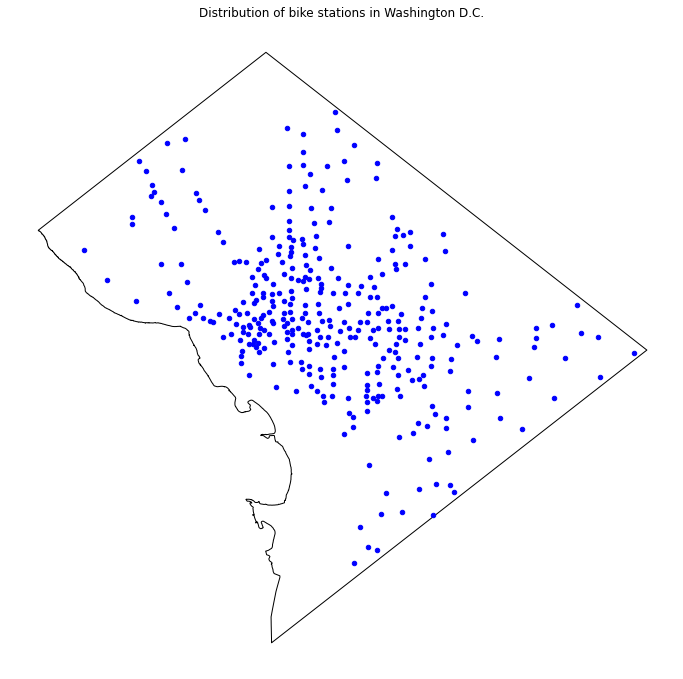

In [10]:
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color = 'white', edgecolor = 'black')
station_info.plot(ax=base1, markersize=20, color='blue', legend=True)  # (bike stations)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis("off")
plt.title('Distribution of bike stations in Washington D.C.')

### OD flow graph for an hour: 01/01/19

#### Morning rush hour

67


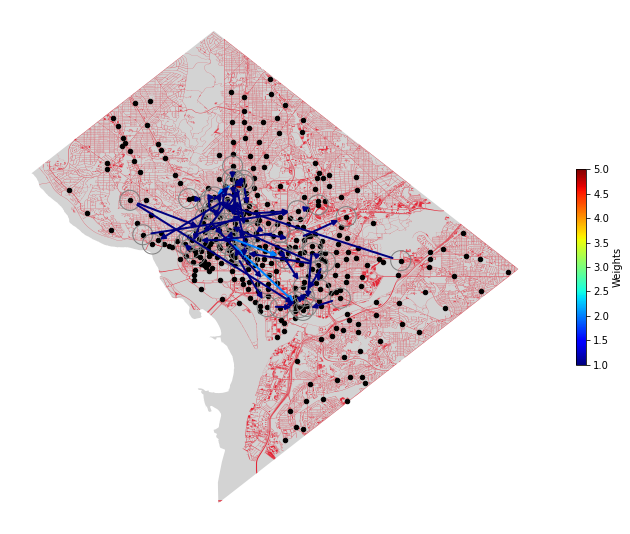

average degree: 0.002435064935064933
average pagerank: 0.002840909090909095
average betweenness: 2.705627705627706e-05


In [11]:
# select one certain time period 8:00 am - 9:00 am, 01/01/19

# draw the graph: nodes, edges, and weights
start_date = datetime(2019, 1, 1, 8)
end_date = datetime(2019, 1, 1, 9)
sharing_bike_data = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date) & (sharingbikedata['Start date'] <= end_date)]
sharing_bike_data = sharing_bike_data.drop(columns={'start_lat', 'start_lon', 'end_lat', 'end_lon'}, axis=1)
print(len(sharing_bike_data))

## calculate weights of different station in a graph
# weight matrix: weights
weights = np.zeros((len(station_info), len(station_info)))
for i in range (len(sharing_bike_data)):
    o_index = station_info[station_info['station_id'] == sharing_bike_data['Start station number'].iloc[i]].index[0]
    d_index = station_info[station_info['station_id'] == sharing_bike_data['End station number'].iloc[i]].index[0]
    weights[o_index, d_index] = weights[o_index, d_index] + 1

# draw a base map of bike ceontriods and DC boudnary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
station_info.plot(ax=base2, markersize=20, color = 'black', legend=True)
plt.axis("off")

# construct a directed graph of bike OD flow trips 
G = nx.DiGraph()
initialpos = {0:station_info.geometry.iloc[0]}
for i in range (1, len(station_info)):
    initialpos.update({i:station_info.geometry.iloc[i]})

initialpos = {k: (v.x, v.y) for k, v in initialpos.items()}
nodes = nx.draw_networkx_nodes(G, initialpos, node_size = 100)
node_index_nonzeros = []
G_weighted_edge = []
for i in range(len(station_info)):
    for j in range(len(station_info)):
        if weights[i][j] != 0:
            G_weighted_edge.append((i, j, int(weights[i][j])))
            node_index_nonzeros.append(i)
            node_index_nonzeros.append(j)
G.add_weighted_edges_from(G_weighted_edge)
node_index_nonzeros = list(set(node_index_nonzeros))
station_info.iloc[node_index_nonzeros].plot(ax=base2, markersize=400, marker='o', facecolors='none', edgecolors='grey')
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, initialpos, edge_color=edge_colors, width=2, edge_cmap=plt.cm.jet) # Blues
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet)
sm.set_array(edge_colors)
plt.colorbar(sm, label = "Weights", orientation = "vertical", shrink = 0.3)
plt.show()

## output statistical metrics

# degree
graph_in_degree = nx.in_degree_centrality(G)
print('average degree:', sum(graph_in_degree.values())/len(station_info))
    
# pagerank
graph_pagerank = nx.pagerank(G)
print('average pagerank:', sum(graph_pagerank.values())/len(station_info))

# betweenness
graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
print('average betweenness:', sum(graph_betweenness.values())/len(station_info))

Text(0, 0.5, 'Count')

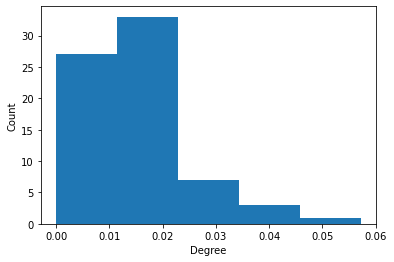

In [12]:
plt.hist(graph_in_degree.values(), bins = 5)
plt.xlabel('Degree')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

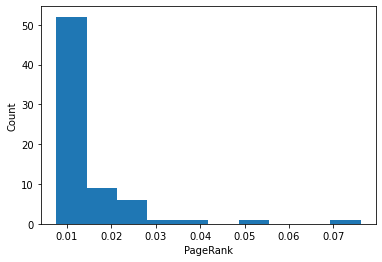

In [13]:
plt.hist(graph_pagerank.values(), bins = 10)
plt.xlabel('PageRank')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

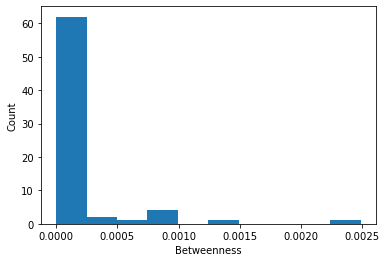

In [14]:
plt.hist(graph_betweenness.values(), bins = 10)
plt.xlabel('Betweenness')
plt.ylabel('Count')

#### Noon

373


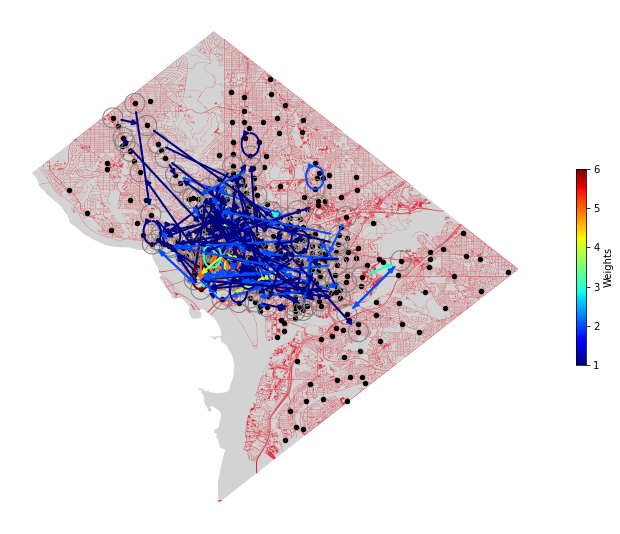

average degree: 0.003986690105474644
average pagerank: 0.0028409090909090966
average betweenness: 0.002811087393269713


In [15]:
# select one certain time period 12:00 pm - 1:00 pm, 01/01/19

# draw the graph: nodes, edges, and weights
start_date = datetime(2019, 1, 1, 12)
end_date = datetime(2019, 1, 1, 13)
sharing_bike_data = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date) & (sharingbikedata['Start date'] <= end_date)]
sharing_bike_data = sharing_bike_data.drop(columns={'start_lat', 'start_lon', 'end_lat', 'end_lon'}, axis=1)
print(len(sharing_bike_data))

## calculate weights of different station in a graph
# weight matrix: weights
weights = np.zeros((len(station_info), len(station_info)))
for i in range (len(sharing_bike_data)):
    o_index = station_info[station_info['station_id'] == sharing_bike_data['Start station number'].iloc[i]].index[0]
    d_index = station_info[station_info['station_id'] == sharing_bike_data['End station number'].iloc[i]].index[0]
    weights[o_index, d_index] = weights[o_index, d_index] + 1

# draw a base map of bike ceontriods and DC boudnary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
station_info.plot(ax=base2, markersize=20, color = 'black', legend=True)
plt.axis("off")

# construct a directed graph of bike OD flow trips 
G = nx.DiGraph()
initialpos = {0:station_info.geometry.iloc[0]}
for i in range (1, len(station_info)):
    initialpos.update({i:station_info.geometry.iloc[i]})

initialpos = {k: (v.x, v.y) for k, v in initialpos.items()}
nodes = nx.draw_networkx_nodes(G, initialpos, node_size = 100)
node_index_nonzeros = []
G_weighted_edge = []
for i in range(len(station_info)):
    for j in range(len(station_info)):
        if weights[i][j] != 0:
            G_weighted_edge.append((i, j, int(weights[i][j])))
            node_index_nonzeros.append(i)
            node_index_nonzeros.append(j)
G.add_weighted_edges_from(G_weighted_edge)
node_index_nonzeros = list(set(node_index_nonzeros))
station_info.iloc[node_index_nonzeros].plot(ax=base2, markersize=400, marker='o', facecolors='none', edgecolors='grey')
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, initialpos, edge_color=edge_colors, width=2, edge_cmap=plt.cm.jet) # Blues
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet)
sm.set_array(edge_colors)
plt.colorbar(sm, label = "Weights", orientation = "vertical", shrink = 0.3)
plt.show()

## output statistical metrics

# degree
graph_in_degree = nx.in_degree_centrality(G)
print('average degree:', sum(graph_in_degree.values())/len(station_info))
    
# pagerank
graph_pagerank = nx.pagerank(G)
print('average pagerank:', sum(graph_pagerank.values())/len(station_info))

# betweenness
graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
print('average betweenness:', sum(graph_betweenness.values())/len(station_info))

#### Evening rush hour

296


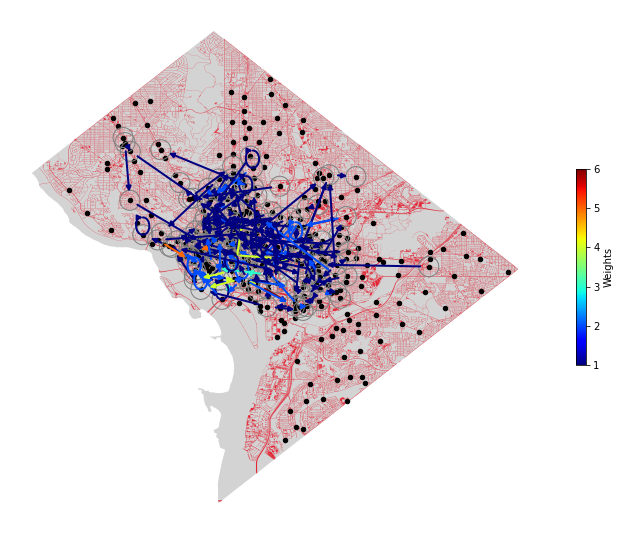

average degree: 0.003875561167227841
average pagerank: 0.0028409090909090897
average betweenness: 0.001073210538790249


In [16]:
# select one certain time period 5:00 pm - 6:00 pm, 01/01/19

# draw the graph: nodes, edges, and weights
start_date = datetime(2019, 1, 1, 17)
end_date = datetime(2019, 1, 1, 18)
sharing_bike_data = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date) & (sharingbikedata['Start date'] <= end_date)]
sharing_bike_data = sharing_bike_data.drop(columns={'start_lat', 'start_lon', 'end_lat', 'end_lon'}, axis=1)
print(len(sharing_bike_data))

## calculate weights of different station in a graph
# weight matrix: weights
weights = np.zeros((len(station_info), len(station_info)))
for i in range (len(sharing_bike_data)):
    o_index = station_info[station_info['station_id'] == sharing_bike_data['Start station number'].iloc[i]].index[0]
    d_index = station_info[station_info['station_id'] == sharing_bike_data['End station number'].iloc[i]].index[0]
    weights[o_index, d_index] = weights[o_index, d_index] + 1

# draw a base map of bike ceontriods and DC boudnary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
station_info.plot(ax=base2, markersize=20, color = 'black', legend=True)
plt.axis("off")

# construct a directed graph of bike OD flow trips 
G = nx.DiGraph()
initialpos = {0:station_info.geometry.iloc[0]}
for i in range (1, len(station_info)):
    initialpos.update({i:station_info.geometry.iloc[i]})

initialpos = {k: (v.x, v.y) for k, v in initialpos.items()}
nodes = nx.draw_networkx_nodes(G, initialpos, node_size = 100)
node_index_nonzeros = []
G_weighted_edge = []
for i in range(len(station_info)):
    for j in range(len(station_info)):
        if weights[i][j] != 0:
            G_weighted_edge.append((i, j, int(weights[i][j])))
            node_index_nonzeros.append(i)
            node_index_nonzeros.append(j)
G.add_weighted_edges_from(G_weighted_edge)
node_index_nonzeros = list(set(node_index_nonzeros))
station_info.iloc[node_index_nonzeros].plot(ax=base2, markersize=400, marker='o', facecolors='none', edgecolors='grey')
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, initialpos, edge_color=edge_colors, width=2, edge_cmap=plt.cm.jet) # Blues
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet)
sm.set_array(edge_colors)
plt.colorbar(sm, label = "Weights", orientation = "vertical", shrink = 0.3)
plt.show()

## output statistical metrics

# degree
graph_in_degree = nx.in_degree_centrality(G)
print('average degree:', sum(graph_in_degree.values())/len(station_info))
    
# pagerank
graph_pagerank = nx.pagerank(G)
print('average pagerank:', sum(graph_pagerank.values())/len(station_info))

# betweenness
graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
print('average betweenness:', sum(graph_betweenness.values())/len(station_info))

Text(0, 0.5, 'Count')

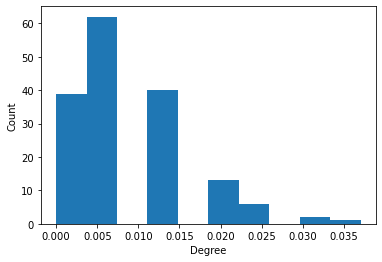

In [17]:
plt.hist(graph_in_degree.values(), bins = 10)
plt.xlabel('Degree')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

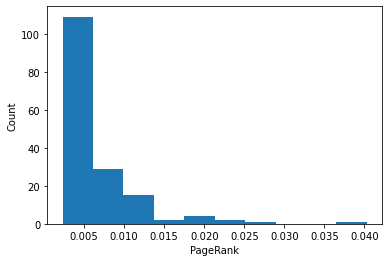

In [18]:
plt.hist(graph_pagerank.values(), bins = 10)
plt.xlabel('PageRank')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

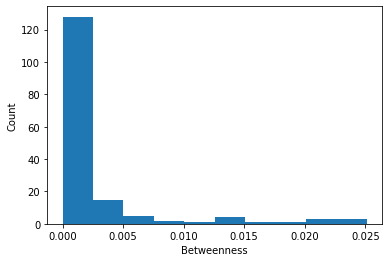

In [19]:
plt.hist(graph_betweenness.values(), bins = 10)
plt.xlabel('Betweenness')
plt.ylabel('Count')

#### Midnight

40


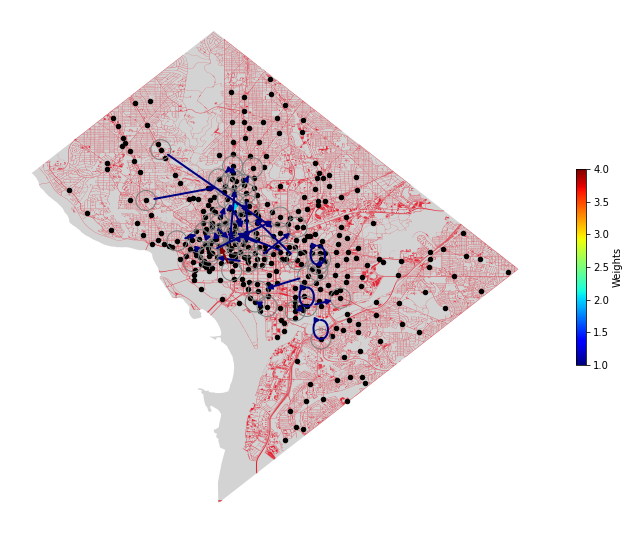

average degree: 0.0018939393939393923
average pagerank: 0.002840909090909089
average betweenness: 9.926307096118417e-06


In [20]:
# select one certain time period 11:00 pm - 12:00 am, 01/01/19

# draw the graph: nodes, edges, and weights
start_date = datetime(2019, 1, 1, 23)
end_date = datetime(2019, 1, 2, 0)
sharing_bike_data = sharingbikedata.loc[(sharingbikedata['Start date'] >= start_date) & (sharingbikedata['Start date'] <= end_date)]
sharing_bike_data = sharing_bike_data.drop(columns={'start_lat', 'start_lon', 'end_lat', 'end_lon'}, axis=1)
print(len(sharing_bike_data))

## calculate weights of different station in a graph
# weight matrix: weights
weights = np.zeros((len(station_info), len(station_info)))
for i in range (len(sharing_bike_data)):
    o_index = station_info[station_info['station_id'] == sharing_bike_data['Start station number'].iloc[i]].index[0]
    d_index = station_info[station_info['station_id'] == sharing_bike_data['End station number'].iloc[i]].index[0]
    weights[o_index, d_index] = weights[o_index, d_index] + 1

# draw a base map of bike ceontriods and DC boudnary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
station_info.plot(ax=base2, markersize=20, color = 'black', legend=True)
plt.axis("off")

# construct a directed graph of bike OD flow trips 
G = nx.DiGraph()
initialpos = {0:station_info.geometry.iloc[0]}
for i in range (1, len(station_info)):
    initialpos.update({i:station_info.geometry.iloc[i]})

initialpos = {k: (v.x, v.y) for k, v in initialpos.items()}
nodes = nx.draw_networkx_nodes(G, initialpos, node_size = 100)
node_index_nonzeros = []
G_weighted_edge = []
for i in range(len(station_info)):
    for j in range(len(station_info)):
        if weights[i][j] != 0:
            G_weighted_edge.append((i, j, int(weights[i][j])))
            node_index_nonzeros.append(i)
            node_index_nonzeros.append(j)
G.add_weighted_edges_from(G_weighted_edge)
node_index_nonzeros = list(set(node_index_nonzeros))
station_info.iloc[node_index_nonzeros].plot(ax=base2, markersize=400, marker='o', facecolors='none', edgecolors='grey')
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, initialpos, edge_color=edge_colors, width=2, edge_cmap=plt.cm.jet) # Blues
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet)
sm.set_array(edge_colors)
plt.colorbar(sm, label = "Weights", orientation = "vertical", shrink = 0.3)
plt.show()

## output statistical metrics

# degree
graph_in_degree = nx.in_degree_centrality(G)
print('average degree:', sum(graph_in_degree.values())/len(station_info))
    
# pagerank
graph_pagerank = nx.pagerank(G)
print('average pagerank:', sum(graph_pagerank.values())/len(station_info))

# betweenness
graph_betweenness = nx.betweenness_centrality(G, normalized=True, endpoints=False)
print('average betweenness:', sum(graph_betweenness.values())/len(station_info))

### Start station ridership

In [21]:
start_station_hour_ridership = pd.read_csv('Data/start_station_hour_ridership.csv')
start_station_hour_ridership.head()

,Start station number,start_month,start_day,start_hour,start_ridership
0,31100.0,1,1,0,1.0
1,31101.0,1,1,0,2.0
2,31102.0,1,1,0,0.0
3,31104.0,1,1,0,2.0
4,31105.0,1,1,0,0.0


#### How many hourly ridership across 352 stations

In [22]:
len(start_station_hour_ridership)

3083520

#### Ratio of Zero Ridership

In [23]:
np.sum(start_station_hour_ridership['start_ridership'] == 0) / len(start_station_hour_ridership)

0.6790560787671233

#### statistics

In [24]:
start_station_hour_ridership.describe()

,Start station number,start_month,start_day,start_hour,start_ridership
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,3.143579e+04,6.526027e+00,1.572055e+01,1.150000e+01,9.322891e-01
std,2.290538e+02,3.447852e+00,8.796248e+00,6.922188e+00,2.144084e+00
min,3.110000e+04,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.125075e+04,4.000000e+00,8.000000e+00,5.750000e+00,0.000000e+00
50%,3.140550e+04,7.000000e+00,1.600000e+01,1.150000e+01,0.000000e+00
75%,3.163425e+04,1.000000e+01,2.300000e+01,1.725000e+01,1.000000e+00
max,3.290100e+04,1.200000e+01,3.100000e+01,2.300000e+01,1.010000e+02


### Temporal Variations

In [25]:
start_hour_ridership = start_station_hour_ridership.groupby(['start_month', 'start_day', 'start_hour']).sum().reset_index()
start_hour_ridership = start_hour_ridership.drop(columns = {'Start station number'}, axis = 1)
start_hour_ridership

,start_month,start_day,start_hour,start_ridership
0,1,1,0,49.0
1,1,1,1,96.0
2,1,1,2,93.0
3,1,1,3,22.0
4,1,1,4,13.0
...,...,...,...,...
8755,12,31,19,155.0
8756,12,31,20,117.0
8757,12,31,21,86.0
8758,12,31,22,67.0


#### Monthly variations

Text(0, 0.5, 'Hourly ridership sum')

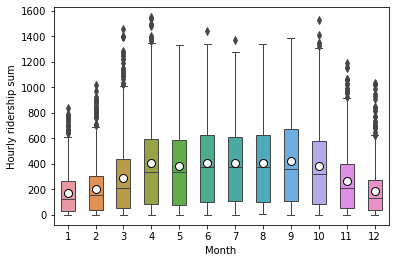

In [26]:
# draw boxplot
sns.boxplot(x = 'start_month', y = 'start_ridership', data = start_hour_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Month')
plt.ylabel('Hourly ridership sum')

#### Weekly variations

Text(0, 0.5, 'Hourly ridership sum')

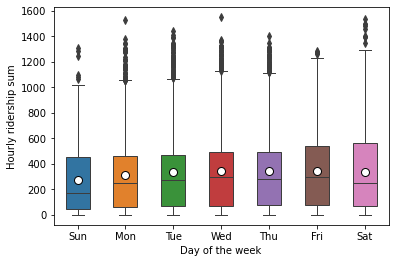

In [27]:
# weekly variation (2019/1/1: Tuesday)
week_list = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
day_num_year = (start_hour_ridership.index/24).astype(int) + 2
start_hour_ridership['start_week'] = day_num_year - (day_num_year/7).astype(int) * 7

# draw boxplot
sns.boxplot(x = 'start_week', y = 'start_ridership', data = start_hour_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xticks(ticks = np.arange(7), labels = week_list)
plt.xlabel('Day of the week')
plt.ylabel('Hourly ridership sum')

#### Hourly variations

Text(0, 0.5, 'Hourly ridership sum')

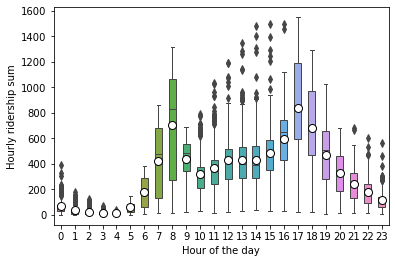

In [28]:
# hourly variation

# draw boxplot
sns.boxplot(x = 'start_hour', y = 'start_ridership', data = start_hour_ridership,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            showfliers = True,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
plt.xlabel('Hour of the day')
plt.ylabel('Hourly ridership sum')

### Spatial Distributions

In [29]:
start_station_ridership = start_station_hour_ridership[['Start station number', 'start_hour', 'start_ridership']].groupby(['Start station number', 'start_hour']).mean().reset_index()
start_station_ridership = start_station_ridership.rename(columns = {'Start station number': 'station_id'})
start_station_ridership = start_station_ridership.merge(station_info[['station_id', 'geometry']], how = 'left', on = 'station_id')
start_station_ridership = gpd.GeoDataFrame(start_station_ridership)
start_station_ridership

,station_id,start_hour,start_ridership,geometry
0,31100.0,0,0.156164,POINT (-77.04290 38.90029)
1,31100.0,1,0.021918,POINT (-77.04290 38.90029)
2,31100.0,2,0.038356,POINT (-77.04290 38.90029)
3,31100.0,3,0.013699,POINT (-77.04290 38.90029)
4,31100.0,4,0.013699,POINT (-77.04290 38.90029)
...,...,...,...,...
8443,32901.0,19,0.000000,POINT (-77.01027 38.96381)
8444,32901.0,20,0.000000,POINT (-77.01027 38.96381)
8445,32901.0,21,0.000000,POINT (-77.01027 38.96381)
8446,32901.0,22,0.000000,POINT (-77.01027 38.96381)


#### Spatial distribution in the morning rush hour

(-77.13032748188984, -76.89861769279194, 38.78142816699374, 39.00618422077411)

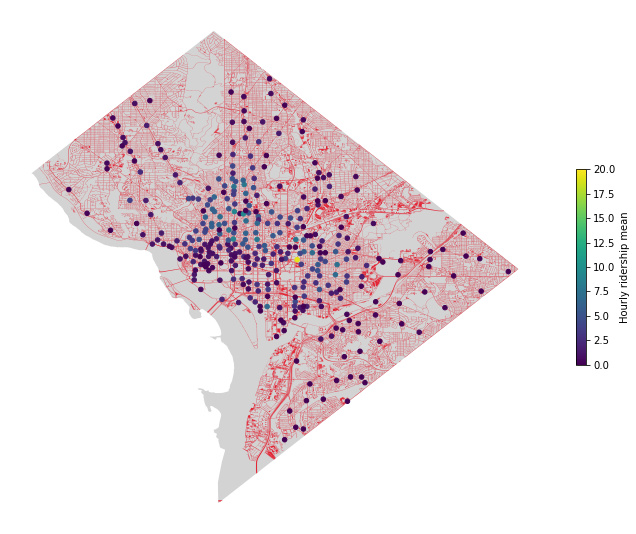

In [30]:
# morning rush hour (8 am)

start_station_ridership_am = start_station_ridership.loc[start_station_ridership['start_hour'] == 8]

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
base3 = start_station_ridership_am.plot(column='start_ridership', ax=base2, markersize=20, 
                                        vmin = 0, vmax = 20,
                                  legend_kwds={'label': "Hourly ridership mean", 'orientation': "vertical", 'shrink': 0.3},
                                  legend=True)
plt.axis('off')

#### Spatial distribution at noon

(-77.13032748188984, -76.89861769279194, 38.78142816699374, 39.00618422077411)

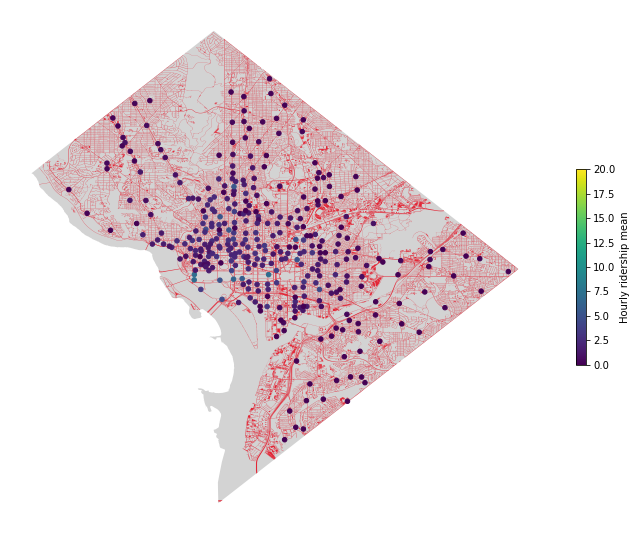

In [31]:
# morning rush hour (12 pm)

start_station_ridership_noon = start_station_ridership.loc[start_station_ridership['start_hour'] == 12]

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
base3 = start_station_ridership_noon.plot(column='start_ridership', ax=base2, markersize=20, 
                                        vmin = 0, vmax = 20,  
                                  legend_kwds={'label': "Hourly ridership mean", 'orientation': "vertical", 'shrink': 0.3},
                                  legend=True)
plt.axis('off')

#### Spatial distribution in the evening rush hour

(-77.13032748188984, -76.89861769279194, 38.78142816699374, 39.00618422077411)

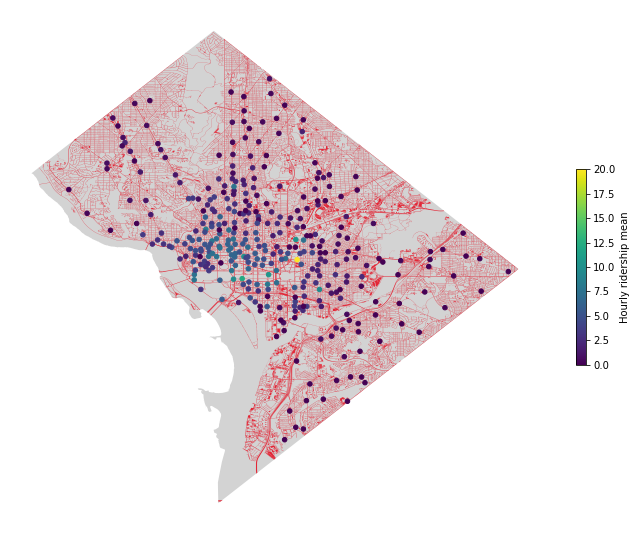

In [32]:
# morning rush hour (17 pm)

start_station_ridership_pm = start_station_ridership.loc[start_station_ridership['start_hour'] == 17]

fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
base3 = start_station_ridership_pm.plot(column='start_ridership', ax=base2, markersize=20, 
                                        vmin = 0, vmax = 20,
                                  legend_kwds={'label': "Hourly ridership mean", 'orientation': "vertical", 'shrink': 0.3},
                                  legend=True)
plt.axis('off')

### End station ridership

In [33]:
end_station_hour_ridership = pd.read_csv('Data/end_station_hour_ridership.csv')
end_station_hour_ridership.head()

,End station number,end_month,end_day,end_hour,end_ridership
0,31100.0,1,1,0,0.0
1,31101.0,1,1,0,2.0
2,31102.0,1,1,0,0.0
3,31104.0,1,1,0,0.0
4,31105.0,1,1,0,0.0


### Without bike station clustering

In [34]:
# buff: 100 m
bike_data_attr_df = pd.read_csv("Data/bike_data_attr_df_buff100.csv")
bike_data_attr_df = bike_data_attr_df.rename(columns = {'metro_stop_dnum_buff1': 'metro_dnum_buff100',
                                                        'bus_stop_dnum_buff1': 'bus_dnum_buff100',
                                                        'metro_stop_snum_buff1': 'metro_snum_buff100',
                                                        'bus_stop_snum_buff1': 'bus_snum_buff100'})
bike_data_attr_df = bike_data_attr_df.drop(columns = {'latitude', 'longitude', 'geometry', 'month', 'day', 'hour', 'station_id'})

# buff: 50m
bike_data_attr_df = pd.concat([bike_data_attr_df, pd.read_csv("Data/bike_data_attr_df_buff50.csv")[['metro_stop_dnum_buff1', 'bus_stop_dnum_buff1', 'metro_stop_snum_buff1', 'bus_stop_snum_buff1']]], axis = 1)
bike_data_attr_df = bike_data_attr_df.rename(columns = {'metro_stop_dnum_buff1': 'metro_dnum_buff50',
                                                        'bus_stop_dnum_buff1': 'bus_dnum_buff50',
                                                        'metro_stop_snum_buff1': 'metro_snum_buff50',
                                                        'bus_stop_snum_buff1': 'bus_snum_buff50'})

# buff: 150m
bike_data_attr_df = pd.concat([bike_data_attr_df, pd.read_csv("Data/bike_data_attr_df_buff150.csv")[['metro_stop_dnum_buff1', 'bus_stop_dnum_buff1', 'metro_stop_snum_buff1', 'bus_stop_snum_buff1']]], axis = 1)
bike_data_attr_df = bike_data_attr_df.rename(columns = {'metro_stop_dnum_buff1': 'metro_dnum_buff150',
                                                        'bus_stop_dnum_buff1': 'bus_dnum_buff150',
                                                        'metro_stop_snum_buff1': 'metro_snum_buff150',
                                                        'bus_stop_snum_buff1': 'bus_snum_buff150'})

# buff: 200m
bike_data_attr_df = pd.concat([bike_data_attr_df, pd.read_csv("Data/bike_data_attr_df_buff200.csv")[['metro_stop_dnum_buff1', 'bus_stop_dnum_buff1', 'metro_stop_snum_buff1', 'bus_stop_snum_buff1']]], axis = 1)
bike_data_attr_df = bike_data_attr_df.rename(columns = {'metro_stop_dnum_buff1': 'metro_dnum_buff200',
                                                        'bus_stop_dnum_buff1': 'bus_dnum_buff200',
                                                        'metro_stop_snum_buff1': 'metro_snum_buff200',
                                                        'bus_stop_snum_buff1': 'bus_snum_buff200'})

# buff: 250m
bike_data_attr_df = pd.concat([bike_data_attr_df, pd.read_csv("Data/bike_data_attr_df_buff250.csv")[['metro_stop_dnum_buff1', 'bus_stop_dnum_buff1', 'metro_stop_snum_buff1', 'bus_stop_snum_buff1']]], axis = 1)
bike_data_attr_df = bike_data_attr_df.rename(columns = {'metro_stop_dnum_buff1': 'metro_dnum_buff250',
                                                        'bus_stop_dnum_buff1': 'bus_dnum_buff250',
                                                        'metro_stop_snum_buff1': 'metro_snum_buff250',
                                                        'bus_stop_snum_buff1': 'bus_snum_buff250'})

bike_data_attr_df.head()

,pop_den,housing_unit_den,LU_diversity,bike_density,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,...,metro_snum_buff150,bus_snum_buff150,metro_dnum_buff200,bus_dnum_buff200,metro_snum_buff200,bus_snum_buff200,metro_dnum_buff250,bus_dnum_buff250,metro_snum_buff250,bus_snum_buff250
0,0.001615,0.001530,1.410208,13.204279,0.0,0.0,0.0,3.0,0.016393,1.0,...,0,3,0,0,0,7,0,0,0,9
1,0.014014,0.010089,2.515274,11.946678,0.0,0.0,0.0,3.0,0.016393,2.0,...,0,4,0,0,0,6,0,0,0,8
2,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.017918,0.014953,2.041013,7.670062,0.0,0.0,0.0,4.0,0.000000,2.0,...,0,5,0,0,0,5,0,0,0,8
4,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
bike_data_attr_df.describe()

,pop_den,housing_unit_den,LU_diversity,bike_density,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,...,metro_snum_buff150,bus_snum_buff150,metro_dnum_buff200,bus_dnum_buff200,metro_snum_buff200,bus_snum_buff200,metro_dnum_buff250,bus_dnum_buff250,metro_snum_buff250,bus_snum_buff250
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,...,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,5.540051e-03,3.611631e-03,1.946706e+00,8.985953e+00,4.665710e+00,1.865948e+01,2.923899e-02,6.827930e-01,4.315927e-03,9.325391e-01,...,4.938155e-02,1.189244e+00,1.282525e+01,5.122420e+01,7.329351e-02,1.892527e+00,1.700788e+01,7.349237e+01,9.825362e-02,2.683846e+00
std,4.539447e-03,3.697743e-03,4.342169e-01,5.745911e+00,3.556956e+01,4.536737e+01,1.684757e-01,1.249737e+00,1.004014e-02,2.144530e+00,...,2.166634e-01,2.015920e+00,6.239549e+01,1.116021e+02,2.749224e-01,2.957241e+00,6.995601e+01,1.569942e+02,3.102589e-01,4.080352e+00
min,1.995632e-06,0.000000e+00,6.106788e-01,2.174771e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.389696e-03,1.512559e-03,1.644312e+00,4.601961e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.012751e-03,2.400653e-03,1.928141e+00,9.181011e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.152860e-03,4.499903e-03,2.240942e+00,1.275088e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.263158e-03,1.000000e+00,...,0.000000e+00,2.000000e+00,0.000000e+00,5.400000e+01,0.000000e+00,3.000000e+00,0.000000e+00,8.700000e+01,0.000000e+00,5.000000e+00
max,2.669692e-02,2.706088e-02,2.809673e+00,2.497542e+01,9.650000e+02,7.320000e+02,1.000000e+00,7.000000e+00,2.000000e+00,1.010000e+02,...,1.000000e+00,1.500000e+01,1.020000e+03,1.760000e+03,2.000000e+00,1.600000e+01,1.020000e+03,2.402000e+03,2.000000e+00,1.900000e+01


### Weather Data

In [35]:
def weather_clean(weather_2019):
    # Datetime format
    weather_2019['Datetime'] = pd.to_datetime(weather_2019['Date'] + " " + weather_2019['Time'])
    weather_2019 = weather_2019.drop(columns = {'Date', 'Time', 'Wind Gust'}, axis = 1)
    # process error data, i.e., temp = 0, convert it into nan
    weather_2019.loc[weather_2019['Temperature'] == 0, 'Temperature'] = np.nan
    weather_2019.loc[weather_2019['Temperature'] == 0, 'Dew Point'] = np.nan
    weather_2019.loc[weather_2019['Temperature'] == 0, 'Humidity'] = np.nan
    weather_2019.loc[weather_2019['Temperature'] == 0, 'Wind Speed'] = np.nan
    weather_2019.loc[weather_2019['Temperature'] == 0, 'Pressure'] = np.nan
    weather_2019.loc[weather_2019['Temperature'] == 0, 'Precip.'] = np.nan
    # process temperature data from F to C
    weather_2019['Temperature'] = (weather_2019['Temperature'] - 32) / 1.8
    weather_2019['Dew Point'] = (weather_2019['Dew Point'] - 32) / 1.8
    # assign numeric value to wind direction
    wd_text = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'VAR', 'CALM']
    wd_num = [0, 22.5, 45, 67.5, 90,  112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5, 0, 0, 0]
    for i in range (len(wd_text)):
        weather_2019.loc[weather_2019['Wind'] == wd_text[i], 'Wind'] = wd_num[i]
    # standard time data for each hour
    month_num = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    weather_data_arr = [[], [], [], [], [], [], [], [], []]
    for month_index in range (1, 13):
        for mm in range(1, month_num[month_index - 1] + 1):
            for nn in range (24):
                start_date = datetime(2019, month_index, mm, nn)
                end_date = start_date + timedelta(hours = 1)
                weather_data = weather_2019.loc[(weather_2019['Datetime'] >= start_date) & (weather_2019['Datetime'] <= end_date)]
                weather_data_arr[0].append(start_date)
                weather_data_arr[1].append(weather_data['Temperature'].mean())
                weather_data_arr[2].append(weather_data['Dew Point'].mean())
                weather_data_arr[3].append(weather_data['Humidity'].mean())
                if weather_data.empty:
                    weather_data_arr[4].append(weather_data['Temperature'].mean())
                    weather_data_arr[8].append(weather_data['Temperature'].mean())
                else:
                    weather_data_arr[4].append(weather_data['Wind'].iloc[0])
                    weather_data_arr[8].append(weather_data['Condition'].iloc[0])
                weather_data_arr[5].append(weather_data['Wind Speed'].mean())
                weather_data_arr[6].append(weather_data['Pressure'].mean())
                weather_data_arr[7].append(weather_data['Precip.'].mean())
    # output final dataframe
    weather_data_2019 = pd.DataFrame({'Datetime': weather_data_arr[0],
                                  'Temp': weather_data_arr[1],
                                  'Dew_Point': weather_data_arr[2],
                                  'Humidity': weather_data_arr[3],
                                  'WD': weather_data_arr[4],
                                  'WS': weather_data_arr[5],
                                  'Pressure': weather_data_arr[6],
                                  'Precipitation': weather_data_arr[7],
                                  'Condition': weather_data_arr[8]})
    return weather_data_2019

weather_DCA_2019 = weather_clean(pd.read_csv("Data/Weather_DCA_2019.csv"))
weather_CGS_2019 = weather_clean(pd.read_csv("Data/Weather_CGS_2019.csv"))
weather_ADW_2019 = weather_clean(pd.read_csv("Data/Weather_ADW_2019.csv"))
weather_IAD_2019 = weather_clean(pd.read_csv("Data/Weather_IAD_2019.csv"))

In [36]:
# define weather station geometry
weather_station_info = pd.DataFrame({'Name': ['DCA', 'CGS', 'ADW', 'IAD'],
                                     'lat': [38.8512, 38.9805, 38.8108, 38.9531],
                                     'lon': [-77.0402, -76.9223, -76.8664, -77.4565]})
weather_station_info['geometry'] = weather_station_info[['lon', 'lat']].values.tolist()
weather_station_info['geometry'] = weather_station_info['geometry'].apply(Point)
# weather_station_info.to_csv('Data/weather_station_info_name.csv', index = False)
weather_station_info

,Name,lat,lon,geometry
0,DCA,38.8512,-77.0402,POINT (-77.0402 38.8512)
1,CGS,38.9805,-76.9223,POINT (-76.9223 38.9805)
2,ADW,38.8108,-76.8664,POINT (-76.8664 38.8108)
3,IAD,38.9531,-77.4565,POINT (-77.4565 38.9531)


In [38]:
# station (352)
station_geo = gpd.GeoDataFrame({'geometry': station_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
weather_station_geo = gpd.GeoDataFrame({'geometry': weather_station_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
weather_station_dist = np.zeros((len(station_geo), len(weather_station_geo)))
for ii in range (len(station_geo)):
    for jj in range (len(weather_station_geo)):
        weather_station_dist[ii, jj] = station_geo.loc[ii, 'geometry'].distance(weather_station_geo.loc[jj, 'geometry'])/1000 # km

column_weather_list = ['Temp', 'Dew_Point', 'Humidity', 'WD', 'WS', 'Pressure', 'Precipitation']
IDW_weather_station = [[], [], [], [], [], [], [], []]
IDW_distance_arr = 1/ ((weather_station_dist) ** 2)
for mm in range (len(weather_DCA_2019)):
    for nn in range (len(column_weather_list)):
        IDW_arr = np.array([weather_DCA_2019.iloc[mm][column_weather_list[nn]], weather_CGS_2019.iloc[mm][column_weather_list[nn]], 
                            weather_ADW_2019.iloc[mm][column_weather_list[nn]], weather_IAD_2019.iloc[mm][column_weather_list[nn]]])
        IDW_arr = np.nan_to_num(IDW_arr, nan=np.nanmean(IDW_arr))
        IDW_weather_station[nn].append(((IDW_distance_arr @ IDW_arr.reshape(-1, 1)).reshape(1, -1) / np.sum(IDW_distance_arr, axis = 1))[0])
    IDW_weather_station[nn + 1].append(np.array(weather_DCA_2019.iloc[mm]['Condition']))

for kk in range (len(column_weather_list)):
    bike_data_attr_df[column_weather_list[kk]] = np.concatenate(IDW_weather_station[kk])
    bike_data_attr_df[column_weather_list[kk]] = bike_data_attr_df[column_weather_list[kk]].fillna(np.nanmean(np.concatenate(IDW_weather_station[kk])))
bike_data_attr_df.head()

,pop_den,housing_unit_den,LU_diversity,bike_density,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,...,bus_dnum_buff250,metro_snum_buff250,bus_snum_buff250,Temp,Dew_Point,Humidity,WD,WS,Pressure,Precipitation
0,0.001615,0.001530,1.410208,13.204279,0.0,0.0,0.0,3.0,0.016393,1.0,...,0,0,9,10.308066,9.384938,93.369540,178.526281,5.772791,29.791229,0.0
1,0.014014,0.010089,2.515274,11.946678,0.0,0.0,0.0,3.0,0.016393,2.0,...,0,0,8,10.070507,9.292673,94.398023,153.867958,5.242584,29.777829,0.0
2,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,9.887703,9.208529,95.083359,134.626540,4.736214,29.772332,0.0
3,0.017918,0.014953,2.041013,7.670062,0.0,0.0,0.0,4.0,0.000000,2.0,...,0,0,8,10.038397,9.275709,94.503864,151.635384,5.199927,29.775953,0.0
4,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,9.946833,9.235818,94.863178,141.204716,4.919094,29.773577,0.0


### POI Data

In [66]:
'''
# Specify the location (place name, city, coordinates, or polygon)
place_name = "Washington D.C., USA"  # Replace with your desired location
pois = ox.geometries_from_place(place_name, tags={'amenity': True})

# Specify the path where you want to save the GeoJSON file
output_geojson_path = "Data/Washington_poi.geojson"

# Save the GeoDataFrame as a GeoJSON file
pois[['geometry', 'amenity', 'ele', 'name']].to_file(output_geojson_path, driver="GeoJSON")
'''

DC_poi_data = gpd.read_file('Data/Washington_poi.geojson')
print(len(DC_poi_data))
print(len(DC_poi_data['amenity'].unique()))
DC_poi_data.head()

15744
126


,element_type,osmid,amenity,ele,name,geometry
0,node,49839253,parking_entrance,None,None,POINT (-77.00272 38.90455)
1,node,60471261,bar,None,Cafe Saint Ex,POINT (-77.03170 38.91542)
2,node,292082777,parking_entrance,None,None,POINT (-77.00945 38.89377)
3,node,292082791,parking_entrance,None,None,POINT (-77.00868 38.89378)
4,node,306011118,fire_station,24,District of Columbia Fire and Emergency Medica...,POINT (-77.01611 38.90769)


In [56]:
for i in range (len(DC_poi_data['amenity'].unique())):
    if np.sum(DC_poi_data['amenity'] == DC_poi_data['amenity'].unique()[i]) > 200: 
        print(DC_poi_data['amenity'].unique()[i], np.sum(DC_poi_data['amenity'] == DC_poi_data['amenity'].unique()[i]))

parking_entrance 238
bar 220
bicycle_parking 546
place_of_worship 591
school 426
parking 6204
bank 253
restaurant 1070
fast_food 516
cafe 340
bench 1704
waste_basket 393
bicycle_rental 402
parking_space 491


In [40]:
# station (352)
bike_geo = gpd.GeoDataFrame({'geometry': station_info.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
poi_geo = gpd.GeoDataFrame({'geometry': DC_poi_data.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')

residential_poi_list = ['grave_yard', 'shelter', 'refuge', 'townhall']
education_poi_list = ['school', 'kindergarten', 'conference_centre', 'research_institute', 'university', 
                      'college', 'dancing_school', 'music_school', 'tutor', 'prep_school', 'language_school']
cultural_poi_list = ['hospital (historic)', 'bell', 'arts_centre', 'library', 'planetarium', 'theatre', 
                     'theatre (historic)', 'archive', 'gallery', 'public_bookcase']
recreational_poi_list = ['bar', 'biergarten', 'alcohol', 'karaoke_box', 'music_venue', 'fountain', 'bench', 
                         'social_club', 'cinema', 'studio', 'pub', 'dojo', 'nightclub', 'stripclub']
social_poi_list = ['community_centre', 'animal_shelter', 'give_box', 'chair', 'lounger', 'trailer_park', 'smoking_area', 
                   'telephone', 'library_dropoff', 'social_centre', 'recycling', 'nursing_home', 'social_facility', 
                   'childcare', 'drinking_water', 'toilets', 'waste_basket']
transportation_poi_list = ['parking_entrance', 'vehicle_inspection', 'parking_space', 'ranger_station',  'boat_rental', 
                           'motorcycle_parking', 'charging_station', 'bicycle_repair_station', 'ferry_terminal', 
                           'bicycle_rental', 'car_rental', 'bicycle_parking', 'parking', 'post_box', 'car_sharing', 
                           'fuel', 'taxi', 'bus_station']
commercial_poi_list = ['bank', 'cloakroom', 'restaurant', 'spa', 'parcel_locker', 'internet_cafe',  'bbq', 'fast_food',
                       'cafe', 'car_wash', 'loading_dock', 'marketplace',  'animal_boarding', 'events_venue', 'dry_cleaner',
                       'nail_salon', 'check_cashing', 'catering', 'ice_cream', 'money_transfer', 
                       'money_transfer;notary_public', 'vending_machine', 'atm', 'coworking_space', 'food_court', 'office']
government_poi_list = ['post_office', 'courthouse', 'government']
religion_poi_list = ['place_of_worship', 'crypt', 'place_of_meditation']
health_poi_list = ['hospital', 'doctors', 'clinic', 'pharmacy', 'veterinary', 'dentist', 'first_aid', 'personal_trainer', ]
publicsafety_poi_list = ['fire_station', 'police', 'border_control']

poi_list = [['OTHERS'], residential_poi_list, education_poi_list, cultural_poi_list, recreational_poi_list, social_poi_list,
            transportation_poi_list, commercial_poi_list, government_poi_list, religion_poi_list, health_poi_list, publicsafety_poi_list]

column_poi_list = ['other_num_buff250', 'residential_num_buff250', 'education_num_buff250', 'cultural_num_buff250',
                   'recreational_num_buff250', 'social_num_buff250', 'transportation_num_buff250', 'commercial_num_buff250',
                   'government_num_buff250', 'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250']

poi_index = np.zeros(len(DC_poi_data))
for mm in range (len(DC_poi_data)):
    for nn in range (len(poi_list)):
        if DC_poi_data['amenity'].iloc[mm] in poi_list[nn]:
            poi_index[mm] = nn
            break
DC_poi_data['index'] = poi_index

bike_poi_num = np.zeros((len(bike_geo), len(poi_list)))
for ii in range (len(bike_geo)):
    for jj in range (len(poi_geo)):
        if bike_geo.geometry.iloc[ii].distance(poi_geo.geometry.iloc[jj]) <= 250:
            bike_poi_num[ii, int(DC_poi_data['index'].iloc[jj])] += 1

station_poi_info = station_info.copy()
for mm in range (len(column_poi_list)):
    station_poi_info[column_poi_list[mm]] = bike_poi_num[:, mm]
station_poi_info.head()

,station_id,latitude,longitude,GEOID,pop_den,median_age,white_ratio,male_ratio,housing_unit_den,LU_diversity,...,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
0,31100.0,38.900289,-77.042902,11001010700,7.203283,31.3,0.835539,0.456207,6.704001,1.410208,...,3.0,2.0,35.0,20.0,37.0,40.0,1.0,2.0,4.0,0.0
1,31101.0,38.917766,-77.032083,11001004300,71.347523,34.6,0.806614,0.445004,46.145930,2.515274,...,4.0,0.0,18.0,3.0,26.0,36.0,1.0,2.0,2.0,0.0
2,31102.0,38.929463,-77.027821,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,...,1.0,2.0,3.0,1.0,10.0,3.0,0.0,2.0,0.0,0.0
3,31104.0,38.922865,-77.042517,11001003901,88.570549,38.1,0.630961,0.369417,66.411150,2.041013,...,2.0,0.0,13.0,1.0,30.0,50.0,0.0,2.0,4.0,1.0
4,31105.0,38.926792,-77.032203,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,...,6.0,0.0,1.0,11.0,36.0,6.0,0.0,1.0,3.0,0.0


In [41]:
# add poi attributes into station_data_attr_df
for mm in range (len(column_poi_list)):
    bike_data_attr_df[column_poi_list[mm]] = np.array(list(station_poi_info[column_poi_list[mm]].values) * 8760)
bike_data_attr_df.head()

,pop_den,housing_unit_den,LU_diversity,bike_density,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,...,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
0,0.001615,0.001530,1.410208,13.204279,0.0,0.0,0.0,3.0,0.016393,1.0,...,3.0,2.0,35.0,20.0,37.0,40.0,1.0,2.0,4.0,0.0
1,0.014014,0.010089,2.515274,11.946678,0.0,0.0,0.0,3.0,0.016393,2.0,...,4.0,0.0,18.0,3.0,26.0,36.0,1.0,2.0,2.0,0.0
2,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.0,2.0,3.0,1.0,10.0,3.0,0.0,2.0,0.0,0.0
3,0.017918,0.014953,2.041013,7.670062,0.0,0.0,0.0,4.0,0.000000,2.0,...,2.0,0.0,13.0,1.0,30.0,50.0,0.0,2.0,4.0,1.0
4,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,6.0,0.0,1.0,11.0,36.0,6.0,0.0,1.0,3.0,0.0


In [57]:
# calcualte poi distance to origin clusters, ferry terminal
amenity_list = ['school', 'bar', 'bench', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'waste_basket', 'place_of_worship']

poi_distance = np.zeros((len(amenity_list), len(station_info)))
for ii in range (len(amenity_list)):
    o_geo = gpd.GeoDataFrame({'geometry': station_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
    for jj in range (len(station_info)):
        index_list = DC_poi_data.loc[DC_poi_data['amenity'] == amenity_list[ii]]
        d_geo = gpd.GeoDataFrame({'geometry': index_list['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
        distance = []
        for kk in range (len(index_list)):
            distance.append(o_geo.iloc[jj].geometry.distance(d_geo.iloc[kk].geometry))
        distance = np.array(distance)
        if len(distance[distance <= 250]) > 0:
            poi_distance[ii,jj] = np.mean(distance[distance <= 250])
        else:     
            poi_distance[ii,jj] = np.min(distance)
station_info[amenity_list] = poi_distance.T
station_info.head()

,station_id,latitude,longitude,GEOID,pop_den,median_age,white_ratio,male_ratio,housing_unit_den,LU_diversity,...,school,bar,bench,fast_food,restaurant,bank,parking,cafe,waste_basket,place_of_worship
0,31100.0,38.900289,-77.042902,11001010700,7.203283,31.3,0.835539,0.456207,6.704001,1.410208,...,298.014670,250.755774,65.545098,196.861902,167.196625,168.988389,172.563974,186.788974,120.533169,213.217963
1,31101.0,38.917766,-77.032083,11001004300,71.347523,34.6,0.806614,0.445004,46.145930,2.515274,...,181.033930,126.100317,162.191231,145.561811,194.600077,109.068886,176.384065,113.698382,193.075265,180.231956
2,31102.0,38.929463,-77.027821,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,...,3.063937,105.171759,473.530310,398.580903,216.957319,391.311224,154.811090,366.140255,212.230060,231.714669
3,31104.0,38.922865,-77.042517,11001003901,88.570549,38.1,0.630961,0.369417,66.411150,2.041013,...,115.117028,124.758377,568.654252,135.965274,130.333636,74.852788,152.255146,103.930870,538.503658,114.225692
4,31105.0,38.926792,-77.032203,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,...,145.862413,246.955320,442.122423,201.192153,239.094483,251.498709,152.975660,233.506179,172.206643,215.066698


In [58]:
#station_info.to_csv('Data/station_att_info_poi.csv', index = False)

### Street View Image Data
- Ensure that your API keys have the necessary permissions and quota to access and download from Google Street View.
- Function Parameters:
    - download_image():
        - lat, lng: Coordinates for the image location.
        - size: Image size (default is '640x480').
        - fov: Field of view (default is 90).
        - heading: Direction of the camera (default is 0).
        - pitch: Vertical angle of the camera (default is 0).
        - radius: Defines search radius in meters (default is 50).
        - source: Source of image (default is 'default').
        - params: Additional parameters to add to the URL (default is None).
        - output_folder: Folder to save the image (default is the current directory).
        - panorama: Download and stitch images from four different headings to create a panoramic image (default is False).
    - batch_download():
        - csv_file: Path to the CSV file with latitude and longitude columns.
        - output_folder: Folder to save the images.
        - api_keys: List of API keys to switch between.
        - images_per_key: Number of images to download before switching to the next API key.
        - panorama: Download panoramic images (default is False).
        - Other parameters are the same as download_image.

#### Process Street View Images Using trained PSPNet to calculate the percentage of each object around stations

In [42]:
station_info_vq = pd.read_csv('Data/station_info_visual_quality.csv')
station_info_vq.head()

,station_id,latitude,longitude,geometry,TRACTCE,pop_den,male_ratio,housing_unit_den,LU_diversity,bike_density,...,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
0,31100.0,38.900289,-77.042902,POINT (-77.04290151498334 38.900288516366665),10700,0.001615,0.467361,0.001530,1.410208,13.204279,...,0.004486,0.084030,0.009561,0.0,0.073057,0.000037,0.000103,0.0,0.000000,0.000053
1,31101.0,38.917766,-77.032083,POINT (-77.0320827701709 38.91776604521078),4300,0.014014,0.440458,0.010089,2.515274,11.946678,...,0.000000,0.099071,0.000928,0.0,0.111770,0.000000,0.000000,0.0,0.002405,0.000000
2,31102.0,38.929463,-77.027821,POINT (-77.02782140873842 38.92946313339121),3000,0.013170,0.409156,0.007601,1.914395,8.725216,...,0.001083,0.159344,0.014701,0.0,0.105715,0.000004,0.000000,0.0,0.000000,0.000708
3,31104.0,38.922865,-77.042517,POINT (-77.04251684149087 38.92286480915612),3901,0.017918,0.405918,0.014953,2.041013,7.670062,...,0.001629,0.153133,0.018368,0.0,0.012791,0.000381,0.000053,0.0,0.000139,0.002259
4,31105.0,38.926792,-77.032203,POINT (-77.0322025645055 38.92679209829671),3000,0.013170,0.409156,0.007601,1.914395,8.725216,...,0.012776,0.146384,0.010834,0.0,0.067491,0.000000,0.000000,0.0,0.000000,0.002252


In [43]:
# add SVIs attributes into bike_data_attr_df
column_vq_list = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation',
    'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle','bicycle'
]

column_vq_pct_list = [
    'SVI_pct_road', 'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
    'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation', 'SVI_pct_terrain', 'SVI_pct_sky', 
    'SVI_pct_person', 'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle','SVI_pct_bicycle'
]

for mm in range (len(column_vq_list)):
    bike_data_attr_df[column_vq_pct_list[mm]] = np.array(list(station_info_vq[column_vq_list[mm]].values) * 8760)
bike_data_attr_df.head()

,pop_den,housing_unit_den,LU_diversity,bike_density,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,...,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
0,0.001615,0.001530,1.410208,13.204279,0.0,0.0,0.0,3.0,0.016393,1.0,...,0.004486,0.084030,0.009561,0.0,0.073057,0.000037,0.000103,0.0,0.000000,0.000053
1,0.014014,0.010089,2.515274,11.946678,0.0,0.0,0.0,3.0,0.016393,2.0,...,0.000000,0.099071,0.000928,0.0,0.111770,0.000000,0.000000,0.0,0.002405,0.000000
2,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.001083,0.159344,0.014701,0.0,0.105715,0.000004,0.000000,0.0,0.000000,0.000708
3,0.017918,0.014953,2.041013,7.670062,0.0,0.0,0.0,4.0,0.000000,2.0,...,0.001629,0.153133,0.018368,0.0,0.012791,0.000381,0.000053,0.0,0.000139,0.002259
4,0.013170,0.007601,1.914395,8.725216,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.012776,0.146384,0.010834,0.0,0.067491,0.000000,0.000000,0.0,0.000000,0.002252


### Replace demographics and built environment POI attributes

In [45]:
bike_data_attr_df = bike_data_attr_df.drop(columns = {'pop_den', 'housing_unit_den', 'LU_diversity', 'bike_density'}, axis = 1)
bike_data_attr_df.head()

,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,pagerank,betweenness,metro_dnum_buff50,bus_dnum_buff50,...,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
0,0.0,0.0,0.0,3.0,0.016393,1.0,0.009620,0.00000,0,0,...,0.004486,0.084030,0.009561,0.0,0.073057,0.000037,0.000103,0.0,0.000000,0.000053
1,0.0,0.0,0.0,3.0,0.016393,2.0,0.017797,0.00082,0,0,...,0.000000,0.099071,0.000928,0.0,0.111770,0.000000,0.000000,0.0,0.002405,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,0.001083,0.159344,0.014701,0.0,0.105715,0.000004,0.000000,0.0,0.000000,0.000708
3,0.0,0.0,0.0,4.0,0.000000,2.0,0.018661,0.00000,0,0,...,0.001629,0.153133,0.018368,0.0,0.012791,0.000381,0.000053,0.0,0.000139,0.002259
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,0.012776,0.146384,0.010834,0.0,0.067491,0.000000,0.000000,0.0,0.000000,0.002252


In [48]:
column_demo_be_list = ['station_id', 'latitude', 'longitude', 'GEOID', 'pop_den', 'median_age', 'white_ratio', 
                       'male_ratio', 'housing_unit_den', 'LU_diversity', 'bike_density', 'geometry']
for mm in range (len(column_demo_be_list)):
    bike_data_attr_df[column_demo_be_list[mm]] = np.array(list(station_info[column_demo_be_list[mm]].values) * 8760)
bike_data_attr_df.head()

,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,pagerank,betweenness,metro_dnum_buff50,bus_dnum_buff50,...,longitude,GEOID,pop_den,median_age,white_ratio,male_ratio,housing_unit_den,LU_diversity,bike_density,geometry
0,0.0,0.0,0.0,3.0,0.016393,1.0,0.009620,0.00000,0,0,...,-77.042902,11001010700,7.203283,31.3,0.835539,0.456207,6.704001,1.410208,17.361177,POINT (-77.04290151498334 38.900288516366665)
1,0.0,0.0,0.0,3.0,0.016393,2.0,0.017797,0.00082,0,0,...,-77.032083,11001004300,71.347523,34.6,0.806614,0.445004,46.145930,2.515274,21.194388,POINT (-77.0320827701709 38.91776604521078)
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,-77.027821,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,11.618369,POINT (-77.02782140873842 38.92946313339121)
3,0.0,0.0,0.0,4.0,0.000000,2.0,0.018661,0.00000,0,0,...,-77.042517,11001003901,88.570549,38.1,0.630961,0.369417,66.411150,2.041013,15.024366,POINT (-77.04251684149087 38.92286480915612)
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,-77.032203,11001003000,74.506295,31.3,0.351470,0.529397,34.313626,1.914395,12.920176,POINT (-77.0322025645055 38.92679209829671)


In [61]:
column_poi_list = ['school', 'bar', 'bench', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'waste_basket', 'place_of_worship']
column_poi_dist_list = ['dist_school', 'dist_bar', 'dist_bench', 'dist_fast_food', 'dist_restaurant', 'dist_bank', 'dist_parking', 'dist_cafe', 'dist_waste_basket', 'dist_place_of_worship']
for mm in range (len(column_poi_list)):
    bike_data_attr_df[column_poi_dist_list[mm]] = np.array(list(station_info[column_poi_list[mm]].values) * 8760)
bike_data_attr_df.head()

,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,pagerank,betweenness,metro_dnum_buff50,bus_dnum_buff50,...,dist_school,dist_bar,dist_bench,dist_fast_food,dist_restaurant,dist_bank,dist_parking,dist_cafe,dist_waste_basket,dist_place_of_worship
0,0.0,0.0,0.0,3.0,0.016393,1.0,0.009620,0.00000,0,0,...,298.014670,250.755774,65.545098,196.861902,167.196625,168.988389,172.563974,186.788974,120.533169,213.217963
1,0.0,0.0,0.0,3.0,0.016393,2.0,0.017797,0.00082,0,0,...,181.033930,126.100317,162.191231,145.561811,194.600077,109.068886,176.384065,113.698382,193.075265,180.231956
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,3.063937,105.171759,473.530310,398.580903,216.957319,391.311224,154.811090,366.140255,212.230060,231.714669
3,0.0,0.0,0.0,4.0,0.000000,2.0,0.018661,0.00000,0,0,...,115.117028,124.758377,568.654252,135.965274,130.333636,74.852788,152.255146,103.930870,538.503658,114.225692
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,145.862413,246.955320,442.122423,201.192153,239.094483,251.498709,152.975660,233.506179,172.206643,215.066698


In [62]:
# bike_data_attr_df.to_csv("Data/bike_data_attr_df_final.csv", index = False)

### Final Data Form

In [63]:
bike_data_attr_df = bike_data_attr_df.drop(columns = {'station_id', 'latitude', 'longitude', 'GEOID', 'geometry'}, axis = 1)
bike_data_attr_df.head()

,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,degree,ridership,pagerank,betweenness,metro_dnum_buff50,bus_dnum_buff50,...,dist_school,dist_bar,dist_bench,dist_fast_food,dist_restaurant,dist_bank,dist_parking,dist_cafe,dist_waste_basket,dist_place_of_worship
0,0.0,0.0,0.0,3.0,0.016393,1.0,0.009620,0.00000,0,0,...,298.014670,250.755774,65.545098,196.861902,167.196625,168.988389,172.563974,186.788974,120.533169,213.217963
1,0.0,0.0,0.0,3.0,0.016393,2.0,0.017797,0.00082,0,0,...,181.033930,126.100317,162.191231,145.561811,194.600077,109.068886,176.384065,113.698382,193.075265,180.231956
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,3.063937,105.171759,473.530310,398.580903,216.957319,391.311224,154.811090,366.140255,212.230060,231.714669
3,0.0,0.0,0.0,4.0,0.000000,2.0,0.018661,0.00000,0,0,...,115.117028,124.758377,568.654252,135.965274,130.333636,74.852788,152.255146,103.930870,538.503658,114.225692
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0,0,...,145.862413,246.955320,442.122423,201.192153,239.094483,251.498709,152.975660,233.506179,172.206643,215.066698


In [64]:
bike_data_attr_df.columns

Index(['metro_dnum_buff100', 'bus_dnum_buff100', 'metro_snum_buff100',
       'bus_snum_buff100', 'degree', 'ridership', 'pagerank', 'betweenness',
       'metro_dnum_buff50', 'bus_dnum_buff50', 'metro_snum_buff50',
       'bus_snum_buff50', 'metro_dnum_buff150', 'bus_dnum_buff150',
       'metro_snum_buff150', 'bus_snum_buff150', 'metro_dnum_buff200',
       'bus_dnum_buff200', 'metro_snum_buff200', 'bus_snum_buff200',
       'metro_dnum_buff250', 'bus_dnum_buff250', 'metro_snum_buff250',
       'bus_snum_buff250', 'Temp', 'Dew_Point', 'Humidity', 'WD', 'WS',
       'Pressure', 'Precipitation', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_

### Descriptive statistics

#### Bike trip data

In [36]:
bike_data_attr_df[['ridership', 'degree', 'pagerank', 'betweenness']].describe()

,ridership,degree,pagerank,betweenness
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,9.325391e-01,4.315927e-03,2.836045e-03,2.725839e-03
std,2.144530e+00,1.004014e-02,8.474771e-03,9.634148e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,5.263158e-03,3.184169e-03,0.000000e+00
max,1.010000e+02,2.000000e+00,1.000000e+00,2.362260e-01


#### socio-demographics

In [67]:
bike_data_attr_df[['pop_den', 'median_age', 'white_ratio', 'male_ratio']].describe()

,pop_den,median_age,white_ratio,male_ratio
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,2.712816e+01,3.358153e+01,5.717825e-01,5.146275e-01
std,2.359616e+01,1.024788e+01,2.894248e-01,1.337871e-01
min,5.976765e-03,0.000000e+00,5.962733e-03,3.142227e-01
25%,1.152092e+01,3.190000e+01,3.514698e-01,4.548495e-01
50%,1.980702e+01,3.430000e+01,6.568699e-01,4.846416e-01
75%,3.669081e+01,3.770000e+01,8.024117e-01,5.278584e-01
max,1.420010e+02,5.510000e+01,1.000000e+00,1.000000e+00


#### weather variables

In [68]:
bike_data_attr_df[['Temp', 'Dew_Point', 'Humidity', 'WD', 'WS',
       'Pressure', 'Precipitation']].describe()

,Temp,Dew_Point,Humidity,WD,WS,Pressure,Precipitation
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,1.505675e+01,7.045102e+00,6.282084e+01,1.418886e+02,7.162131e+00,2.996139e+01,1.989771e-03
std,1.011917e+01,1.005445e+01,1.831935e+01,1.013767e+02,4.545670e+00,3.980663e-01,1.968262e-02
min,-1.321364e+01,-2.654002e+01,5.511327e+00,0.000000e+00,0.000000e+00,1.700379e+01,0.000000e+00
25%,6.342229e+00,-6.290644e-01,4.849377e+01,4.748895e+01,4.041382e+00,2.983696e+01,0.000000e+00
50%,1.597171e+01,8.129809e+00,6.315239e+01,1.396384e+02,6.392691e+00,2.998390e+01,0.000000e+00
75%,2.353538e+01,1.593866e+01,7.771809e+01,2.052036e+02,9.664862e+00,3.013471e+01,0.000000e+00
max,3.662642e+01,2.531483e+01,9.987298e+01,3.375000e+02,3.129157e+01,3.074697e+01,1.758907e+00


#### built environment attributes

In [69]:
bike_data_attr_df[['housing_unit_den', 'LU_diversity', 'bike_density']].describe()

,housing_unit_den,LU_diversity,bike_density
count,3.083520e+06,3.083520e+06,3.083520e+06
mean,1.615049e+01,1.946706e+00,1.122278e+01
std,1.657783e+01,4.342169e-01,7.945107e+00
min,0.000000e+00,6.106788e-01,0.000000e+00
25%,6.704001e+00,1.644312e+00,4.348488e+00
50%,1.056402e+01,1.928141e+00,1.009342e+01
75%,1.996881e+01,2.240942e+00,1.736206e+01
max,1.154896e+02,2.809673e+00,2.847857e+01


#### POI

In [70]:
# distance metric
bike_data_attr_df[['dist_school', 'dist_bar', 'dist_bench',
       'dist_fast_food', 'dist_restaurant', 'dist_bank', 'dist_parking',
       'dist_cafe', 'dist_waste_basket', 'dist_place_of_worship']].describe()

,dist_school,dist_bar,dist_bench,dist_fast_food,dist_restaurant,dist_bank,dist_parking,dist_cafe,dist_waste_basket,dist_place_of_worship
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,3.322414e+02,8.445928e+02,5.021515e+02,3.424941e+02,3.366797e+02,4.954196e+02,1.629215e+02,5.288900e+02,5.714944e+02,2.933911e+02
std,2.566002e+02,1.060308e+03,4.407763e+02,3.068714e+02,3.700185e+02,4.232474e+02,4.026089e+01,7.295509e+02,5.383815e+02,2.382005e+02
min,3.063937e+00,3.232357e+01,1.148774e+01,2.138157e+01,3.165236e+01,8.606254e+00,5.018526e+01,2.832839e+01,1.976103e+01,2.827241e+01
25%,1.685896e+02,1.981284e+02,2.099827e+02,1.486963e+02,1.442296e+02,1.732308e+02,1.449512e+02,1.619091e+02,2.097383e+02,1.568187e+02
50%,2.642617e+02,4.428178e+02,3.626418e+02,2.242050e+02,1.890407e+02,3.315589e+02,1.585151e+02,2.310208e+02,4.310032e+02,2.091659e+02
75%,4.144261e+02,9.198541e+02,6.444035e+02,4.357038e+02,3.683644e+02,7.177080e+02,1.786419e+02,5.193809e+02,7.173835e+02,3.564655e+02
max,1.676731e+03,6.244427e+03,2.795653e+03,1.822658e+03,2.297026e+03,2.446006e+03,5.796588e+02,4.854856e+03,3.310383e+03,1.606142e+03


In [71]:
# count metric
bike_data_attr_df[['other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250']].describe()

,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,1.164773e-01,3.892045e-01,1.573864e+00,6.392045e-01,7.142045e+00,2.656250e+00,1.743466e+01,1.122159e+01,2.784091e-01,1.244318e+00,8.437500e-01,1.960227e-01
std,3.380444e-01,1.235920e+00,1.614986e+00,1.129636e+00,1.372714e+01,5.477591e+00,1.450769e+01,1.445356e+01,6.714891e-01,1.392950e+00,1.279656e+00,4.691459e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.750000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.500000e+01,6.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,7.000000e+00,2.250000e+00,2.200000e+01,1.600000e+01,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
max,2.000000e+00,1.100000e+01,9.000000e+00,7.000000e+00,1.220000e+02,4.700000e+01,2.270000e+02,6.700000e+01,5.000000e+00,7.000000e+00,1.000000e+01,3.000000e+00


#### SVIs

In [72]:
bike_data_attr_df[['SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle']].describe()

,SVI_pct_road,SVI_pct_sidewalk,SVI_pct_building,SVI_pct_wall,SVI_pct_fence,SVI_pct_pole,SVI_pct_traffic_light,SVI_pct_traffic_sign,SVI_pct_vegetation,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,2.641707e-01,4.416851e-02,1.870752e-01,5.900491e-03,9.772464e-03,7.835335e-03,6.301233e-04,1.396706e-03,2.317253e-01,3.384644e-02,1.382334e-01,1.008686e-02,1.491385e-04,5.779286e-02,2.508785e-03,7.328866e-04,5.723202e-05,1.226830e-03,2.690707e-03
std,6.464859e-02,3.527164e-02,1.291787e-01,1.099199e-02,1.664894e-02,5.324251e-03,1.257011e-03,2.244780e-03,1.186383e-01,4.505629e-02,7.859940e-02,1.467175e-02,5.732084e-04,4.969720e-02,1.509122e-02,3.131557e-03,8.062763e-04,3.571030e-03,6.612856e-03
min,7.790771e-02,0.000000e+00,1.394857e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.197917e-03,0.000000e+00,5.576172e-03,0.000000e+00,0.000000e+00,2.360026e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.142228e-01,1.735372e-02,7.767354e-02,1.393636e-04,6.789144e-04,3.820394e-03,0.000000e+00,2.697754e-04,1.346444e-01,3.983765e-03,7.980387e-02,3.640747e-03,0.000000e+00,1.746562e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.616272e-01,3.541423e-02,1.665499e-01,1.445312e-03,3.574626e-03,6.714681e-03,4.435221e-05,7.523600e-04,2.208301e-01,1.563436e-02,1.219922e-01,7.087402e-03,0.000000e+00,4.238322e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.949056e-04
75%,3.103546e-01,6.471598e-02,2.753056e-01,6.608073e-03,1.104960e-02,1.046061e-02,6.097412e-04,1.578166e-03,3.249180e-01,4.733317e-02,1.850214e-01,1.297607e-02,1.017253e-06,8.796549e-02,1.188151e-04,2.034505e-07,0.000000e+00,7.202148e-04,2.506510e-03
max,4.653963e-01,1.783219e-01,5.518709e-01,9.522054e-02,1.131527e-01,3.513265e-02,6.958822e-03,1.988688e-02,5.540511e-01,3.591553e-01,4.186247e-01,2.322729e-01,6.392415e-03,2.498682e-01,1.781340e-01,4.090495e-02,1.484294e-02,3.246826e-02,6.352539e-02


#### public transit effects

In [37]:
bike_data_attr_df[[
       'metro_dnum_buff50', 'bus_dnum_buff50', 'metro_snum_buff50',
       'bus_snum_buff50', 'metro_dnum_buff100', 'bus_dnum_buff100', 'metro_snum_buff100',
       'bus_snum_buff100', 'metro_dnum_buff150', 'bus_dnum_buff150',
       'metro_snum_buff150', 'bus_snum_buff150', 'metro_dnum_buff200',
       'bus_dnum_buff200', 'metro_snum_buff200', 'bus_snum_buff200',
       'metro_dnum_buff250', 'bus_dnum_buff250', 'metro_snum_buff250',
       'bus_snum_buff250']].describe()

,metro_dnum_buff50,bus_dnum_buff50,metro_snum_buff50,bus_snum_buff50,metro_dnum_buff100,bus_dnum_buff100,metro_snum_buff100,bus_snum_buff100,metro_dnum_buff150,bus_dnum_buff150,metro_snum_buff150,bus_snum_buff150,metro_dnum_buff200,bus_dnum_buff200,metro_snum_buff200,bus_snum_buff200,metro_dnum_buff250,bus_dnum_buff250,metro_snum_buff250,bus_snum_buff250
count,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06,3.083520e+06
mean,2.276390e+00,6.823285e+00,1.342881e-02,2.518891e-01,4.665710e+00,1.865948e+01,2.923899e-02,6.827930e-01,8.210429e+00,3.267369e+01,4.938155e-02,1.189244e+00,1.282525e+01,5.122420e+01,7.329351e-02,1.892527e+00,1.700788e+01,7.349237e+01,9.825362e-02,2.683846e+00
std,2.522630e+01,2.258506e+01,1.151020e-01,6.142474e-01,3.556956e+01,4.536737e+01,1.684757e-01,1.249737e+00,4.768557e+01,7.651296e+01,2.166634e-01,2.015920e+00,6.239549e+01,1.116021e+02,2.749224e-01,2.957241e+00,6.995601e+01,1.569942e+02,3.102589e-01,4.080352e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.600000e+01,0.000000e+00,2.000000e+00,0.000000e+00,5.400000e+01,0.000000e+00,3.000000e+00,0.000000e+00,8.700000e+01,0.000000e+00,5.000000e+00
max,9.650000e+02,4.130000e+02,1.000000e+00,4.000000e+00,9.650000e+02,7.320000e+02,1.000000e+00,7.000000e+00,9.650000e+02,1.431000e+03,1.000000e+00,1.500000e+01,1.020000e+03,1.760000e+03,2.000000e+00,1.600000e+01,1.020000e+03,2.402000e+03,2.000000e+00,1.900000e+01


### Example of all variables for regression models
- Bike station: bike_data_attr_df & station_info (352 bike stations, data order: 352-352-352, for each hour, over the entire year)
- Bike centroid: centroid_data_attr_df & K_centroids_info (100 bike centroids: data order: 100-100-100, for each hour, over the entire year)

### Variable Selection Based on SpVAR-LASSO Model

#### ACF

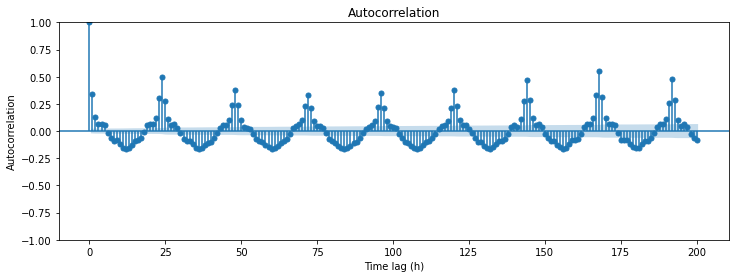

In [47]:
# ACF for one bike centroid: 352 bike stations
import statsmodels.api as sm

bike_data_attr_arr = bike_data_attr_df.copy()
fig, ax = plt.subplots(figsize=(12, 4))
station_index = 0 # 0-351
station_data_arr = np.arange(24*365) * len(station_info) + station_index
sm.graphics.tsa.plot_acf(np.array(bike_data_attr_arr.iloc[:, 9])[station_data_arr], lags = 200, ax=ax)
plt.xlabel('Time lag (h)')
plt.ylabel('Autocorrelation')
plt.show()

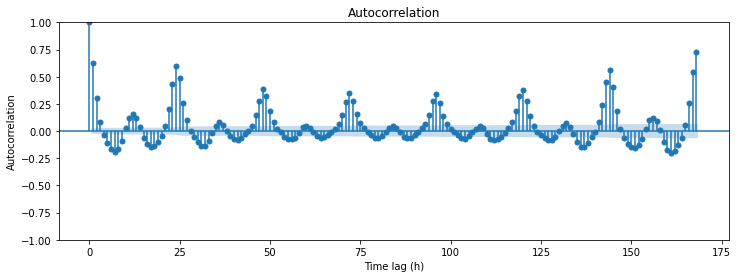

In [48]:
# ACF for one bike centroid: 100 bike centroids
import statsmodels.api as sm

centroid_data_attr_arr = centroid_data_attr_df.copy()
fig, ax = plt.subplots(figsize=(12, 4))
station_index = 0 # 0:99
station_data_arr = np.arange(24*365) * len(K_centroid_info) + station_index
sm.graphics.tsa.plot_acf(np.array(centroid_data_attr_arr.iloc[:, 9])[station_data_arr], lags = 168, ax=ax)
plt.xlabel('Time lag (h)')
plt.ylabel('Autocorrelation')
plt.show()

#### Geographic adjacency matrix

In [41]:
# geographical adjacency matrix based on physical proximity (352*352)
station_geometry = gpd.GeoDataFrame({'geometry': station_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
bike_gw_station = np.zeros((len(station_info), len(station_info)))
for i in range (len(station_info)):
    for j in range (i+1, len(station_info)):
        bike_gw_station[i,j] = 1000/station_geometry.iloc[i][0].distance(station_geometry.iloc[j][0]) #1/(dist/1000)
bike_gw_station = bike_gw_station + bike_gw_station.T # 352*352
bike_gw_station

array([[0.        , 0.44354217, 0.27368272, ..., 0.1548067 , 0.24598945,
        0.12580753],
       [0.44354217, 0.        , 0.7080484 , ..., 0.12667469, 0.20324917,
        0.17538994],
       [0.27368272, 0.7080484 , 0.        , ..., 0.10988311, 0.16657689,
        0.23283956],
       ...,
       [0.1548067 , 0.12667469, 0.10988311, ..., 0.        , 0.31185739,
        0.07774233],
       [0.24598945, 0.20324917, 0.16657689, ..., 0.31185739, 0.        ,
        0.10354924],
       [0.12580753, 0.17538994, 0.23283956, ..., 0.07774233, 0.10354924,
        0.        ]])

In [42]:
# geographical adjacency matrix based on physical proximity (100*100)
centroid_geometry = gpd.GeoDataFrame({'geometry': K_centroid_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
gw_centroid = np.zeros((len(K_centroid_info), len(K_centroid_info)))
for i in range (len(K_centroid_info)):
    for j in range (i+1, len(K_centroid_info)):
        gw_centroid[i,j] = 1000/centroid_geometry.iloc[i][0].distance(centroid_geometry.iloc[j][0]) #1/(dist/1000)
gw_centroid = gw_centroid + gw_centroid.T # 100*100
gw_centroid

array([[0.        , 0.64411504, 0.19754037, ..., 0.09085113, 0.10609868,
        0.18875428],
       [0.64411504, 0.        , 0.15261505, ..., 0.08009947, 0.09341146,
        0.14995813],
       [0.19754037, 0.15261505, 0.        , ..., 0.16820552, 0.20439312,
        0.82806313],
       ...,
       [0.09085113, 0.08009947, 0.16820552, ..., 0.        , 0.28168885,
        0.16802426],
       [0.10609868, 0.09341146, 0.20439312, ..., 0.28168885, 0.        ,
        0.23929655],
       [0.18875428, 0.14995813, 0.82806313, ..., 0.16802426, 0.23929655,
        0.        ]])

#### SpVAR-LASSO model for each hour

In [ ]:
## SpVAR-LASSO Model for centroid (352)

# define two kinds of spatial relationship, along with weight matrix
station_neighbors = {}
station_gw_weights = {}
for i in range(len(station_info)):
    aa = list(np.arange(len(station_info)))
    aa.remove(i)
    station_neighbors[i] = aa
    bb = list(bike_gw_station[i, :])
    bb.remove(0)
    station_gw_weights[i] = list(np.array(bb) + 1e-4)

# Create a PySAL W object with the station_neighbors and weights
station_gw_w = ps.weights.W(station_neighbors, weights = station_gw_weights)
station_gw_w.transform = 'r'

bike_data_attr_arr = np.array(bike_data_attr_arr)
bike_data_attr_arr[:,9] = bike_data_attr_arr[:,9] + np.random.rand(len(bike_data_attr_arr))/1e3 # ridership column, avoid zero data

order_step = 168
time_list = np.arange(order_step)
station_mse_dataset = []
station_coef_dataset = []
station_pred_dataset = []
for i in range (order_step, np.arange(24*365)): # len(bike_data_array): np.arange(24*365)
    station_spatial_reg = pd.DataFrame({'demand_pred': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),9],
                                     #'degree': bike_data_array[i,:,-5],
                                     #'pagerank': bike_data_array[i,:,-3],
                                     #'betweenness': bike_data_array[i,:,-2],
                                     'pop_density': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),0],
                                     'housing_unit_den': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),1],
                                     'LU_diversity': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),2],
                                     'bike_density': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),3],
                                     'metro_stop_dnum_buff1': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),4] + np.random.rand(len(station_info))/1e4,
                                     'bus_stop_dnum_buff1': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),5] + np.random.rand(len(station_info))/1e4,
                                     'metro_stop_snum_buff1': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),6] + np.random.rand(len(station_info))/1e4,
                                     'bus_stop_snum_buff1': bike_data_attr_arr[i*len(station_info):(i+1)*len(station_info),7] + np.random.rand(len(station_info))/1e4})
    
    for j in time_list: # time_list
        station_spatial_reg[str(-j-1)] = bike_data_attr_arr[(i-j-1)*len(station_info):(i-j)*len(station_info),9]

    # Load data
    station_spatial_reg = station_spatial_reg.values
    X = station_spatial_reg[:, 1:]
    y = station_spatial_reg[:, 0]

    print(i)

    # Create spatial vector autoregressive Lasso model
    model = GM_Lag(y, X, w=station_gw_w)

    # Fit model with Lasso regularization using cross-validation
    alphas = np.logspace(-4, 2, num=100)
    station_lasso_cv = LassoCV(alphas=alphas, cv=10)
    station_lasso_cv.fit(model.x, model.y)

    # Evaluate model performance
    pred = station_lasso_cv.predict(model.x)
    station_pred_dataset.append(pred)
    
    mse = np.mean((pred - model.y.reshape(1,-1)[0]) ** 2)
    station_mse_dataset.append(mse)
    station_coef_dataset.append(station_lasso_cv.coef_)
    

In [65]:
## SpVAR-LASSO Model for centroid (100)

# define two kinds of spatial relationship, along with weight matrix
centroid_neighbors = {}
centroid_gw_weights = {}
for i in range(len(K_centroid_info)):
    aa = list(np.arange(len(K_centroid_info)))
    aa.remove(i)
    centroid_neighbors[i] = aa
    bb = list(gw_centroid[i, :])
    bb.remove(0)
    centroid_gw_weights[i] = list(np.array(bb) + 1e-4)

# Create a PySAL W object with the neighbors and weights
centroid_gw_w = ps.weights.W(centroid_neighbors, weights = centroid_gw_weights)
centroid_gw_w.transform = 'r'

centroid_data_attr_arr = np.array(centroid_data_attr_arr)
centroid_data_attr_arr[:,9] = centroid_data_attr_arr[:,9] + np.random.rand(len(centroid_data_attr_arr))/1e3 # ridership column, avoid zero data

# to avoid attr_num > len(K_centroid_info)
time_list = list(np.arange(29))  # remove the data before and after 7 hour at 1,2,3,4,5,6,7days
for i in [43, 67, 91, 115, 139, 163]:
    for j in range(10):
        time_list.append(i+j)
time_list = np.array(time_list[0:-5])

order_step = 168
centroid_mse_dataset = []
centroid_coef_dataset = []
centroid_pred_dataset = []
for i in range (order_step, np.arange(24*365)): # len(bike_data_array): np.arange(24*365)
    centroid_spatial_reg = pd.DataFrame({'demand_pred': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),9],
                                     #'degree': bike_data_array[i,:,-5],
                                     #'pagerank': bike_data_array[i,:,-3],
                                     #'betweenness': bike_data_array[i,:,-2],
                                     'pop_density': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),0],
                                     'housing_unit_den': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),1],
                                     'LU_diversity': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),2],
                                     'bike_density': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),3],
                                     'metro_stop_dnum_buff1': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),4] + np.random.rand(len(K_centroid_info))/1e4,
                                     'bus_stop_dnum_buff1': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),5] + np.random.rand(len(K_centroid_info))/1e4,
                                     'metro_stop_snum_buff1': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),6] + np.random.rand(len(K_centroid_info))/1e4,
                                     'bus_stop_snum_buff1': centroid_data_attr_arr[i*len(K_centroid_info):(i+1)*len(K_centroid_info),7] + np.random.rand(len(K_centroid_info))/1e4})
    
    for j in time_list: # time_list
        centroid_spatial_reg[str(-j-1)] = centroid_data_attr_arr[(i-j-1)*len(K_centroid_info):(i-j)*len(K_centroid_info),9]

    # Load data
    centroid_spatial_reg = centroid_spatial_reg.values
    X = centroid_spatial_reg[:, 1:]
    y = centroid_spatial_reg[:, 0]

    print(i)

    # Create spatial vector autoregressive Lasso model
    model = GM_Lag(y, X, w=centroid_gw_w)

    # Fit model with Lasso regularization using cross-validation
    alphas = np.logspace(-4, 2, num=100)
    centroid_lasso_cv = LassoCV(alphas=alphas, cv=10)
    centroid_lasso_cv.fit(model.x, model.y)

    # Evaluate model performance
    pred = centroid_lasso_cv.predict(model.x)
    centroid_pred_dataset.append(pred)
    
    mse = np.mean((pred - model.y.reshape(1,-1)[0]) ** 2)
    centroid_mse_dataset.append(mse)
    centroid_coef_dataset.append(centroid_lasso_cv.coef_)
    

168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215


#### Cross validation plots

In [ ]:
## CV plots (352)
alphas = np.logspace(-4, 2, num=100)
station_CV_alphas_output = station_lasso_cv.mse_path_
station_CV_alphas_mean = np.mean(station_CV_alphas_output, axis = 1)
station_CV_alphas_std = np.std(station_CV_alphas_output, axis = 1)
print(alphas[np.where(station_CV_alphas_mean == min(station_CV_alphas_mean))[0]])

# Plot the data with error bars
plt.figure (figsize = (8,4))
plt.errorbar(np.log10(alphas), station_CV_alphas_mean, yerr = station_CV_alphas_std, fmt='o', capsize=4)

lamda = r'$ Log(\lambda$)'

# Add labels and a title
plt.xlabel(f'{lamda}')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

[0.03053856]


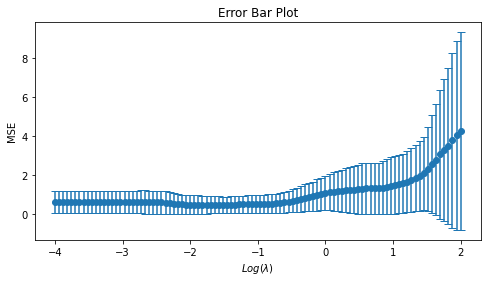

In [66]:
## CV plots (100)
alphas = np.logspace(-4, 2, num=100)
centroid_CV_alphas_output = centroid_lasso_cv.mse_path_
centroid_CV_alphas_mean = np.mean(centroid_CV_alphas_output, axis = 1)
centroid_CV_alphas_std = np.std(centroid_CV_alphas_output, axis = 1)
print(alphas[np.where(centroid_CV_alphas_mean == min(centroid_CV_alphas_mean))[0]])

# Plot the data with error bars
plt.figure (figsize = (8,4))
plt.errorbar(np.log10(alphas), centroid_CV_alphas_mean, yerr = centroid_CV_alphas_std, fmt='o', capsize=4)

lamda = r'$ Log(\lambda$)'

# Add labels and a title
plt.xlabel(f'{lamda}')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

#### Observation & Prediction

In [ ]:
# 352
station_pred_dataset = np.array(station_pred_dataset)
plt.figure(figsize = (12, 4))
station_index = 72
l1 = plt.plot(station_pred_dataset[:,station_index], 'blue') # 73th centroid
l2 = plt.plot(bike_data_attr_arr[np.arange(order_step, 216) * len(station_info) + station_index, 9], 'orange')
plt.xlabel('Time')
plt.ylabel('Ridership')
plt.legend(['Predictions', 'Observations'])
plt.show()

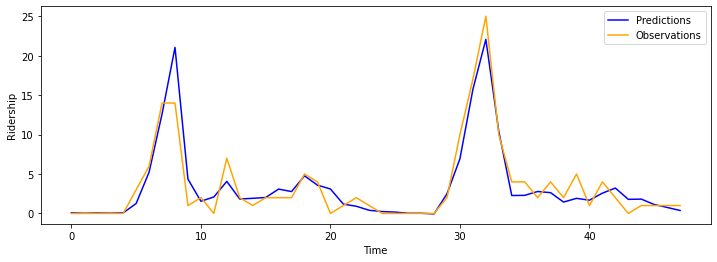

In [67]:
# 100
centroid_pred_dataset = np.array(centroid_pred_dataset)
plt.figure(figsize = (12, 4))
station_index = 72
l1 = plt.plot(centroid_pred_dataset[:,station_index], 'blue') # 73th centroid
l2 = plt.plot(centroid_data_attr_arr[np.arange(order_step, 216) * len(K_centroid_info) + station_index, 9], 'orange')
plt.xlabel('Time')
plt.ylabel('Ridership')
plt.legend(['Predictions', 'Observations'])
plt.show()

#### MSE Histogram for all regressions

In [ ]:
# 352
station_mse_dataset = np.array(station_mse_dataset)
l1 = plt.hist(station_mse_dataset, bins = 100, density = True)
plt.xlabel('MSE')
plt.ylabel('Probability density')

Text(0, 0.5, 'Probability density')

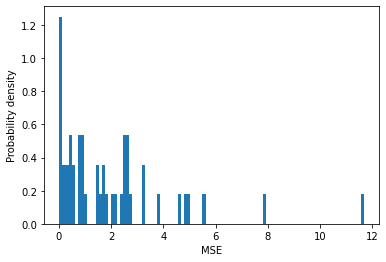

In [68]:
# 100
centroid_mse_dataset = np.array(centroid_mse_dataset)
l1 = plt.hist(centroid_mse_dataset, bins = 100, density = True)
plt.xlabel('MSE')
plt.ylabel('Probability density')

#### MSE Errorbar for all regression by hour of day

In [ ]:
# 352
station_mse_dataset_plot = station_mse_dataset.reshape((int(len(station_mse_dataset)/24)), 24)
station_mse_dataset_plot_mean = np.mean(station_mse_dataset_plot, axis = 0)
station_mse_dataset_plot_std = np.std(station_mse_dataset_plot, axis = 0)
plt.errorbar(np.arange(24), station_mse_dataset_plot_mean, yerr = station_mse_dataset_plot_std, fmt='o', capsize=2)

# Add labels and a title
plt.xlabel('Hour of day')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

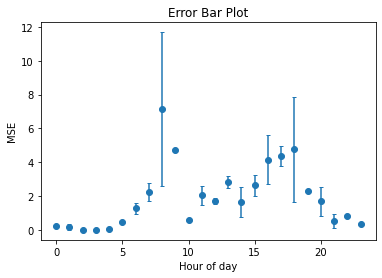

In [73]:
# 100
centroid_mse_dataset_plot = centroid_mse_dataset.reshape((int(len(centroid_mse_dataset)/24)), 24)
centroid_mse_dataset_plot_mean = np.mean(centroid_mse_dataset_plot, axis = 0)
centroid_mse_dataset_plot_std = np.std(centroid_mse_dataset_plot, axis = 0)
plt.errorbar(np.arange(24), centroid_mse_dataset_plot_mean, yerr = centroid_mse_dataset_plot_std, fmt='o', capsize=2)

# Add labels and a title
plt.xlabel('Hour of day')
plt.ylabel('MSE')
plt.title('Error Bar Plot')

# Show the plot
plt.show()

#### Showing of crucial feaytures with non-zero regression coefficient

In [ ]:
# 352
station_coef_dataset = np.array(station_coef_dataset)

non_zero_count = []
for i in range (station_coef_dataset.shape[1]):
    non_zero_count.append(np.sum(station_coef_dataset[:, i] != 0))
non_zero_count = np.array(non_zero_count)
index_list_nonzero = np.where(non_zero_count >= 90) # threshold
print(index_list_nonzero[0])
print(non_zero_count[index_list_nonzero[0]])

# 'metro_stop_dnum', 'bus_stop_dnum', 'bus_stop_snum', lag24, lag72, lag96, lag120, lag144, lag168 
# order: 'bus_stop_dnum', 'metro_stop_dnum', lag168, lag24, 'bus_stop_snum', lag144, lag96, lag72, lag120,

station_data_coef_est = pd.DataFrame({'bus_stop_dnum_buff1': station_coef_dataset[:, index_list_nonzero[0][1]],
                              'metro_stop_dnum_buff1': station_coef_dataset[:, index_list_nonzero[0][0]],
                              'Lag168': station_coef_dataset[:, index_list_nonzero[0][8]],
                              'Lag24': station_coef_dataset[:, index_list_nonzero[0][3]],
                              'Lag144': station_coef_dataset[:, index_list_nonzero[0][7]],
                              'bus_stop_snum_buff1': station_coef_dataset[:, index_list_nonzero[0][2]],
                              'Lag96': station_coef_dataset[:, index_list_nonzero[0][5]],
                              'Lag72': station_coef_dataset[:, index_list_nonzero[0][4]],
                              'Lag120': station_coef_dataset[:, index_list_nonzero[0][6]]})

# draw boxplot
plt.figure(figsize = (12, 4))
sns.boxplot(data = station_data_coef_est,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            flierprops = dict(marker='D', markersize=3),
            #showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
#plt.ylim([-0.2, 0.6])
plt.xlabel('Independent variables')
plt.xticks(rotation = 45)
plt.ylabel('Coefficient estimates')
plt.title('Percentage of non-zero coefficients')  # 576 regression equations

[ 5  6  8 32 52 62 72 82 92]
[374 530  95 109  91  94  90  96 114]


Text(0.5, 1.0, 'Percentage of non-zero coefficients')

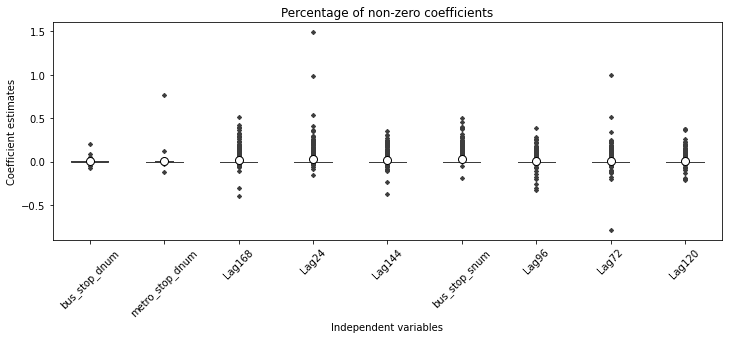

In [35]:
# 100
centroid_coef_dataset = np.array(centroid_coef_dataset)

non_zero_count = []
for i in range (centroid_coef_dataset.shape[1]):
    non_zero_count.append(np.sum(centroid_coef_dataset[:, i] != 0))
non_zero_count = np.array(non_zero_count)
index_list_nonzero = np.where(non_zero_count >= 90)
print(index_list_nonzero[0])
print(non_zero_count[index_list_nonzero[0]])

# 'metro_stop_dnum', 'bus_stop_dnum', 'bus_stop_snum', lag24, lag72, lag96, lag120, lag144, lag168 
# order: 'bus_stop_dnum', 'metro_stop_dnum', lag168, lag24, 'bus_stop_snum', lag144, lag96, lag72, lag120,

centroid_data_coef_est = pd.DataFrame({'bus_stop_dnum_buff1': centroid_coef_dataset[:, index_list_nonzero[0][1]],
                              'metro_stop_dnum_buff1': centroid_coef_dataset[:, index_list_nonzero[0][0]],
                              'Lag168': centroid_coef_dataset[:, index_list_nonzero[0][8]],
                              'Lag24': centroid_coef_dataset[:, index_list_nonzero[0][3]],
                              'Lag144': centroid_coef_dataset[:, index_list_nonzero[0][7]],
                              'bus_stop_snum_buff1': centroid_coef_dataset[:, index_list_nonzero[0][2]],
                              'Lag96': centroid_coef_dataset[:, index_list_nonzero[0][5]],
                              'Lag72': centroid_coef_dataset[:, index_list_nonzero[0][4]],
                              'Lag120': centroid_coef_dataset[:, index_list_nonzero[0][6]]})

# draw boxplot
plt.figure(figsize = (12, 4))
sns.boxplot(data = centroid_data_coef_est,
            linewidth = 1, 
            saturation=0.75, 
            width=0.5,
            flierprops = dict(marker='D', markersize=3),
            #showfliers = False,
            showmeans = True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"})
#plt.ylim([-0.2, 0.6])
plt.xlabel('Independent variables')
plt.xticks(rotation = 45)
plt.ylabel('Coefficient estimates')
plt.title('Percentage of non-zero coefficients')  # 576 regression equations

### Bike station clustering based on temporal patterns of hourly ridership

#### Data preparation

In [17]:
station_hour_ridership = start_station_hour_ridership.merge(end_station_hour_ridership,
                                                            left_on = ['Start station number', 'start_month', 'start_day', 'start_hour'],
                                                            right_on = ['End station number', 'end_month', 'end_day', 'end_hour'],
                                                            how = 'left')
station_hour_ridership = station_hour_ridership.rename(columns = {'Start station number': 'station_id',
                                                                  'start_month': 'month',
                                                                  'start_day': 'day',
                                                                  'start_hour': 'hour'})
station_hour_ridership = station_hour_ridership.drop(columns = {'End station number', 'end_month', 'end_day', 'end_hour'}, axis = 1)
station_hour_ridership.head()

,station_id,month,day,hour,start_ridership,end_ridership
0,31100.0,1,1,0,1.0,0.0
1,31101.0,1,1,0,2.0,2.0
2,31102.0,1,1,0,0.0,0.0
3,31104.0,1,1,0,2.0,0.0
4,31105.0,1,1,0,0.0,0.0


In [18]:
station_hour_ridership_start_arr = np.array(station_hour_ridership['start_ridership']).reshape((8760, 352)).T
station_hour_ridership_end_arr = np.array(station_hour_ridership['end_ridership']).reshape((8760, 352)).T

#### GMM for clustering

Text(0, 0.5, 'Silhouette')

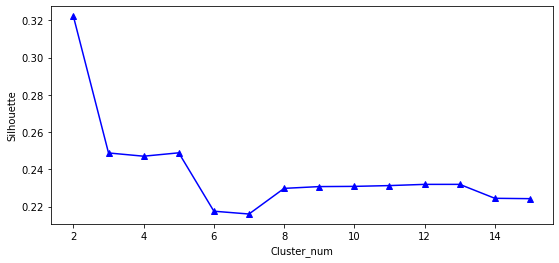

In [19]:
cluster_num = np.arange(2, 16)
# cluster_assign_list = []
score_list = [0.32219541564658555, 0.24885445502167733, 0.24710773908344194, 0.24892039576266906, 0.21757855799439108,
              0.2160720951783213, 0.22983476228929878, 0.23079190176285758, 0.23090913548620173, 0.23133194584334502,
              0.2319848617638092, 0.23198862134250486, 0.22450523743108483, 0.22430975866784494]
plt.figure(figsize = (9, 4))
plt.plot(cluster_num, score_list, 'b^-')
plt.xlabel('Cluster_num')
plt.ylabel('Silhouette')

#### Select and run the optimal cluster num

In [20]:
# standardize the dataset
scaler = StandardScaler()
normalized_data = scaler.fit_transform(station_hour_ridership_start_arr)

# define the number of clusters
num_clusters = 2
# Fit the GMM model
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(normalized_data)
# Predict clusters
cluster_assignments = gmm.predict(normalized_data)
# Evaluation results
silhouette_avg = silhouette_score(normalized_data, cluster_assignments)
print("Cluster number:", num_clusters)
print("Silhouette Score:", silhouette_avg)
for i in range (num_clusters):
    print('cluster {}:'.format(i))
    print('Data points are {}.'.format(np.sum(cluster_assignments == i)))

Cluster number: 2
Silhouette Score: 0.32219541564658555
cluster 0:
Data points are 116.
cluster 1:
Data points are 236.


#### Output the cluster results

In [21]:
## Num of clusters = 2
cluster_list = ['cluster_1', 'cluster_2'] # 'cluster_3', 'cluster_4', 'cluster_5'
station_ridership_start_info = station_hour_ridership[['station_id', 'start_ridership', 'end_ridership']].groupby('station_id').sum().reset_index()
station_ridership_start_info = station_ridership_start_info.merge(station_info[['station_id', 'geometry']], on = 'station_id', how = 'left')
station_ridership_start_info['start_cluster'] = cluster_assignments
for i in range(len(cluster_list)):
    station_ridership_start_info['start_cluster'].loc[station_ridership_start_info['start_cluster'] == i] = cluster_list[i]
station_ridership_start_info = gpd.GeoDataFrame(station_ridership_start_info)
station_ridership_start_info.head()

,station_id,start_ridership,end_ridership,geometry,start_cluster
0,31100.0,6823.0,7102.0,POINT (-77.04290 38.90029),cluster_2
1,31101.0,26215.0,31411.0,POINT (-77.03208 38.91777),cluster_1
2,31102.0,13545.0,7788.0,POINT (-77.02782 38.92946),cluster_1
3,31104.0,17611.0,14950.0,POINT (-77.04252 38.92286),cluster_1
4,31105.0,8637.0,3472.0,POINT (-77.03220 38.92679),cluster_2


#### Visualization GMM cluster in a map (with DC roads)

(-77.13032748188984, -76.89861769279194, 38.78142816699374, 39.00618422077411)

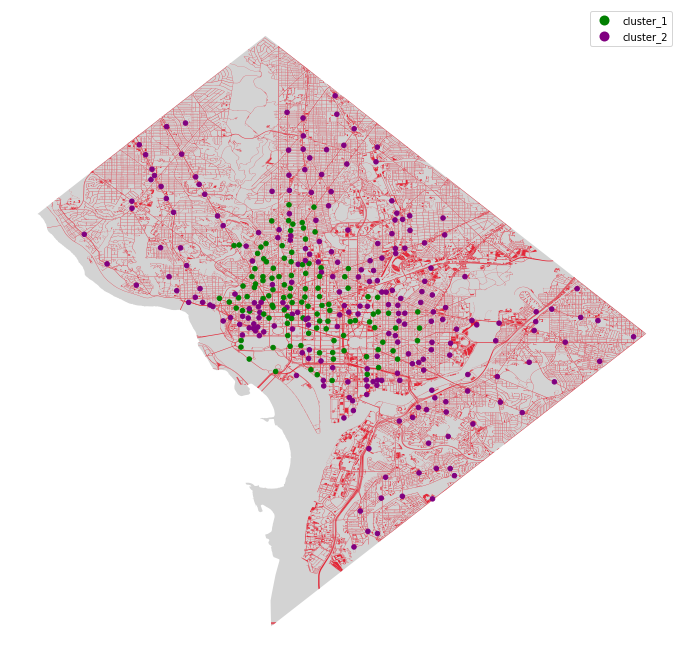

In [22]:
# draw a base map of bike ceontriods and DC boudnary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color='#d3d3d3')
base2 = DC_road_info.plot(ax=base1, color='#e32636')
bike_palette = {'cluster_1': 'purple', 'cluster_2': 'green'} # 'cluster_3': 'orange', 'cluster_4': 'purple', 'cluster_5': 'teal'
# 'green','lightblue','orange','purple','teal'
cmap = matplotlib.colors.ListedColormap([bike_palette[b] for b in station_ridership_start_info.start_cluster.unique()])
station_ridership_start_info.plot(column = 'start_cluster', ax=base2, cmap = cmap, markersize=20, legend=True)
plt.axis("off")

#### Visualization GMM cluster in a map (without DC road) 

(-77.13032748188984, -76.89861769279194, 38.78142816699374, 39.00618422077411)

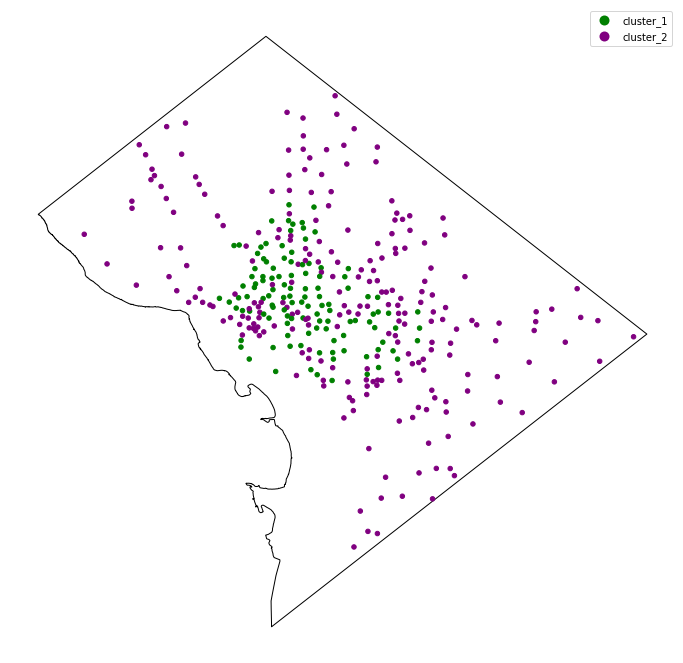

In [23]:
# draw a base map of bike ceontriods and DC boudnary
fig, ax = plt.subplots(1, figsize=(12,12))
divider = make_axes_locatable(ax)
base1 = DC_boundary.plot(ax=ax, color = 'white', edgecolor = 'black')
bike_palette = {'cluster_1': 'purple', 'cluster_2': 'green'} # , 'cluster_3': 'orange', 'cluster_4': 'purple', 'cluster_5': 'teal'
# 'green','lightblue','orange','purple','teal'
cmap = matplotlib.colors.ListedColormap([bike_palette[b] for b in station_ridership_start_info.start_cluster.unique()])
station_ridership_start_info.plot(column = 'start_cluster', ax=base1, cmap = cmap, markersize=20, legend=True)
plt.axis("off")

#### Show total ridership distribution for each cluster (Scatter)

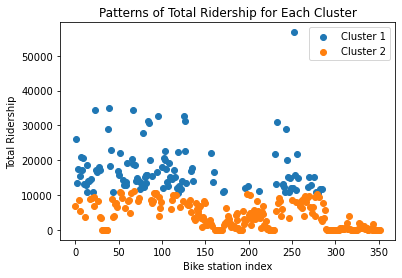

In [24]:
# Add cluster assignments to the DataFrame
num_clusters = 2
cluster_list = ['cluster_1', 'cluster_2']
# Plot temporal patterns for each cluster
for cluster in range(num_clusters):
    cluster_data = station_ridership_start_info[station_ridership_start_info['start_cluster'] == cluster_list[cluster]]
    # cluster_data.drop('start_cluster', axis=1).mean().plot(label=f'Cluster {cluster+1}')
    plt.scatter(np.array(cluster_data['start_ridership'].index), np.array(cluster_data['start_ridership']), label=f'Cluster {cluster+1}')
    
plt.title('Patterns of Total Ridership for Each Cluster')
plt.xlabel('Bike station index')
plt.ylabel('Total Ridership')
plt.legend()
plt.show()

#### Show total ridership distribution for each cluster (Plot)

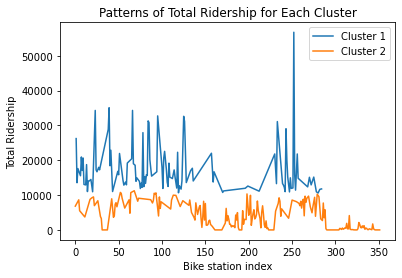

In [25]:
# Add cluster assignments to the DataFrame
num_clusters = 2
cluster_list = ['cluster_1', 'cluster_2']
# Plot temporal patterns for each cluster
for cluster in range(num_clusters):
    cluster_data = station_ridership_start_info[station_ridership_start_info['start_cluster'] == cluster_list[cluster]]
    # cluster_data.drop('start_cluster', axis=1).mean().plot(label=f'Cluster {cluster+1}')
    cluster_data['start_ridership'].plot(label=f'Cluster {cluster+1}')
    
plt.title('Patterns of Total Ridership for Each Cluster')
plt.xlabel('Bike station index')
plt.ylabel('Total Ridership')
plt.legend()
plt.show()

#### show all ridership distribution for each cluster (Scatter)

In [26]:
# add cluster into station_hour_ridership
station_hour_ridership_cluster = station_hour_ridership.merge(station_ridership_start_info[['station_id', 'start_cluster']],
                                                              on = 'station_id',
                                                              how = 'left')
station_hour_ridership_cluster.head()

,station_id,month,day,hour,start_ridership,end_ridership,start_cluster
0,31100.0,1,1,0,1.0,0.0,cluster_2
1,31101.0,1,1,0,2.0,2.0,cluster_1
2,31102.0,1,1,0,0.0,0.0,cluster_1
3,31104.0,1,1,0,2.0,0.0,cluster_1
4,31105.0,1,1,0,0.0,0.0,cluster_2


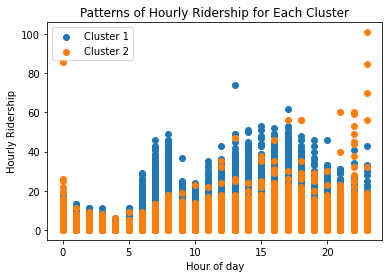

In [27]:
# Add cluster assignments to the DataFrame
num_clusters = 2
cluster_list = ['cluster_1', 'cluster_2']
# Plot temporal patterns for each cluster
for cluster in range(num_clusters):
    cluster_data = station_hour_ridership_cluster[station_hour_ridership_cluster['start_cluster'] == cluster_list[cluster]]
    # cluster_data.drop('start_cluster', axis=1).mean().plot(label=f'Cluster {cluster+1}')
    plt.scatter(np.array(cluster_data['hour']), np.array(cluster_data['start_ridership']), label=f'Cluster {cluster+1}')
    
plt.title('Patterns of Hourly Ridership for Each Cluster')
plt.xlabel('Hour of day')
plt.ylabel('Hourly Ridership')
plt.legend()
plt.show()

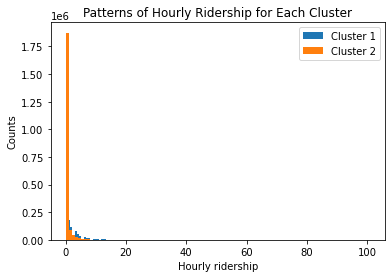

In [28]:
# Add cluster assignments to the DataFrame
num_clusters = 2
cluster_list = ['cluster_1', 'cluster_2']
# Plot temporal patterns for each cluster
for cluster in range(num_clusters):
    cluster_data = station_hour_ridership_cluster[station_hour_ridership_cluster['start_cluster'] == cluster_list[cluster]]
    # cluster_data.drop('start_cluster', axis=1).mean().plot(label=f'Cluster {cluster+1}')
    plt.hist(np.array(cluster_data['start_ridership']), bins = 100, label=f'Cluster {cluster+1}')
    
plt.title('Patterns of Hourly Ridership for Each Cluster')
plt.xlabel('Hourly ridership')
plt.ylabel('Counts')
plt.legend()
plt.show()

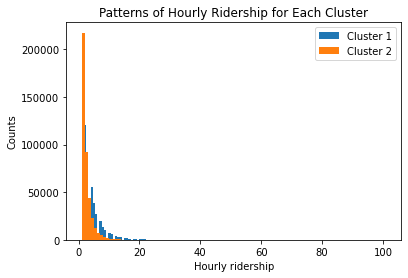

In [29]:
# non-zero dataset
num_clusters = 2
cluster_list = ['cluster_1', 'cluster_2']
# Plot temporal patterns for each cluster
for cluster in range(num_clusters):
    cluster_data = station_hour_ridership_cluster[station_hour_ridership_cluster['start_cluster'] == cluster_list[cluster]]
    cluster_data = cluster_data.loc[cluster_data['start_ridership'] != 0]
    # cluster_data.drop('start_cluster', axis=1).mean().plot(label=f'Cluster {cluster+1}')
    plt.hist(np.array(cluster_data['start_ridership']), bins = 100, label=f'Cluster {cluster+1}')
    
plt.title('Patterns of Hourly Ridership for Each Cluster')
plt.xlabel('Hourly ridership')
plt.ylabel('Counts')
plt.legend()
plt.show()

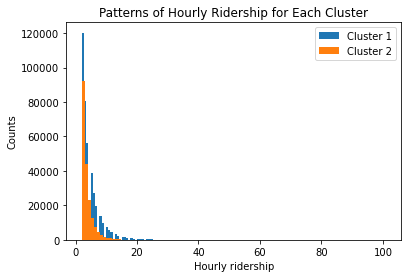

In [30]:
# >1 dataset: over certain number
num_clusters = 2
cluster_list = ['cluster_1', 'cluster_2']
# Plot temporal patterns for each cluster
for cluster in range(num_clusters):
    cluster_data = station_hour_ridership_cluster[station_hour_ridership_cluster['start_cluster'] == cluster_list[cluster]]
    cluster_data = cluster_data.loc[cluster_data['start_ridership'] > 1]
    # cluster_data.drop('start_cluster', axis=1).mean().plot(label=f'Cluster {cluster+1}')
    plt.hist(np.array(cluster_data['start_ridership']), bins = 100, label=f'Cluster {cluster+1}')
    
plt.title('Patterns of Hourly Ridership for Each Cluster')
plt.xlabel('Hourly ridership')
plt.ylabel('Counts')
plt.legend()
plt.show()

### Data preparation

In [37]:
## data preparation: array (time * bike_centroid : 744-order * 100)

order = 168

# hourly demand: dependent variables
lag_0 = np.array(bike_data_attribute_array)[order:,:,-1]

# temporal features: lag24, lag72, lag96, lag120, lag144, lag168: independent variables
lag_24 = np.array(bike_data_attribute_array)[order-24:-24,:,-1]
lag_72 = np.array(bike_data_attribute_array)[order-72:-72,:,-1]
lag_96 = np.array(bike_data_attribute_array)[order-96:-96,:,-1]
lag_120 = np.array(bike_data_attribute_array)[order-120:-120,:,-1]
lag_144 = np.array(bike_data_attribute_array)[order-144:-144,:,-1]
lag_168 = np.array(bike_data_attribute_array)[order-168:-168,:,-1]

# public transit information: metro_stop_dnum, metro_stop_snum, bus_stop_dnum, bus_stop_snum: independent variables
metro_dnum_0 = np.array(bike_data_attribute_array)[order:,:,4]
bus_dnum_0 = np.array(bike_data_attribute_array)[order:,:,5]
bus_snum_0 = np.array(bike_data_attribute_array)[order:,:,7]

# time-lagged (24,72,96,120,144,168h lagged) graph: degree, pagerank, betweenness: independent variables
degree_24 = np.array(bike_data_attribute_array)[order-24:-24,:,8]
pagerank_24 = np.array(bike_data_attribute_array)[order-24:-24,:,10]
betweenness_24 = np.array(bike_data_attribute_array)[order-24:-24,:,11]

degree_72 = np.array(bike_data_attribute_array)[order-72:-72,:,8]
pagerank_72 = np.array(bike_data_attribute_array)[order-72:-72,:,10]
betweenness_72 = np.array(bike_data_attribute_array)[order-72:-72,:,11]

degree_96 = np.array(bike_data_attribute_array)[order-96:-96,:,8]
pagerank_96 = np.array(bike_data_attribute_array)[order-96:-96,:,10]
betweenness_96 = np.array(bike_data_attribute_array)[order-96:-96,:,11]

degree_120 = np.array(bike_data_attribute_array)[order-120:-120,:,8]
pagerank_120 = np.array(bike_data_attribute_array)[order-120:-120,:,10]
betweenness_120 = np.array(bike_data_attribute_array)[order-120:-120,:,11]

degree_144 = np.array(bike_data_attribute_array)[order-144:-144,:,8]
pagerank_144 = np.array(bike_data_attribute_array)[order-144:-144,:,10]
betweenness_144 = np.array(bike_data_attribute_array)[order-144:-144,:,11]

degree_168 = np.array(bike_data_attribute_array)[order-168:-168,:,8]
pagerank_168 = np.array(bike_data_attribute_array)[order-168:-168,:,10]
betweenness_168 = np.array(bike_data_attribute_array)[order-168:-168,:,11]

#### Descriptive statistics of bike centroids

In [38]:
# descriptive statistics: hourly ridership, graph, public transit
K_centroid_info[['pop_den', 'housing_unit_den', 'LU_diversity', 'bike_density']].describe()

,pop_den,housing_unit_den,LU_diversity,bike_density
count,100.000000,100.000000,100.000000,100.000000
mean,0.005227,0.003383,1.941334,0.276106
std,0.003681,0.002918,0.382158,0.202498
min,0.000002,0.000000,0.610679,0.008792
25%,0.002606,0.001442,1.728750,0.126218
50%,0.003969,0.002430,1.957349,0.242730
75%,0.006921,0.004178,2.170007,0.393001
max,0.015973,0.013069,2.632981,1.000000


In [39]:
# descriptive statistics: built environment factors
tripfactor_data_stat = pd.DataFrame({'hour_ridership': np.array(bike_data_attribute_array)[:,:,-1].flatten(),
                                     'degree': np.array(bike_data_attribute_array)[:,:,8].flatten(),
                                     'pagerank': np.array(bike_data_attribute_array)[:,:,10].flatten(),
                                     'betweenness': np.array(bike_data_attribute_array)[:,:,11].flatten(),
                                     'metro_dnum': np.array(bike_data_attribute_array)[:,:,4].flatten(),
                                     'bus_dnum': np.array(bike_data_attribute_array)[:,:,5].flatten(),
                                     'metro_snum': np.array(bike_data_attribute_array)[:,:,6].flatten(),
                                     'bus_snum': np.array(bike_data_attribute_array)[:,:,7].flatten()})
tripfactor_data_stat.describe()

,hour_ridership,degree,pagerank,betweenness,metro_dnum,bus_dnum,metro_snum,bus_snum
count,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000,74400.000000
mean,1.797097,0.020799,0.009839,0.008102,9.228616,55.784315,0.068199,1.911694
std,3.979097,0.040614,0.025001,0.021485,38.762549,104.859229,0.252089,2.748796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.002350,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.028571,0.011532,0.002163,0.000000,76.000000,0.000000,4.000000
max,72.000000,2.000000,1.000000,0.500000,383.000000,1119.000000,1.000000,15.000000


#### Meteorology data

In [46]:
# meteorology: hourly visibility, temperature, dew point temp, humidity, wind speed, direction, and precipitation: independent variables (all stations share the same values)
meteorology = pd.read_csv('Data/weather_data_march.csv')
meteorology['Date'] = pd.to_datetime(meteorology['Date'])
meteorology['Day'] = meteorology['Date'].dt.day
meteorology['Hour'] = meteorology['Date'].dt.hour

# convert it into hourly stastics baased on date
meteorology_1 = meteorology.copy()
meteorology_1 = meteorology_1.drop(columns = {'Date'}, axis = 1)
meteorology_hourly = meteorology_1.groupby(['Day', 'Hour']).mean()
meteorology_0 = meteorology_hourly.values
print(meteorology_0.shape)
meteorology_0  # hourly values * 7 weather variables = 744 * 7

(744, 7)


array([[ 1.00000000e+01,  6.00000000e-01, -1.11000000e+01, ...,
         9.00000000e+00,  3.00000000e+02,  0.00000000e+00],
       [ 9.97000000e+00,  3.00000000e-01, -1.08500000e+01, ...,
         8.50000000e+00,  3.05000000e+02,  0.00000000e+00],
       [ 1.00000000e+01, -6.00000000e-01, -1.06000000e+01, ...,
         5.00000000e+00,  3.40000000e+02,  0.00000000e+00],
       ...,
       [ 1.00000000e+01,  7.20000000e+00,  5.60000000e+00, ...,
         1.30000000e+01,  6.00000000e+01,  3.33333333e-03],
       [ 9.98500000e+00,  6.95000000e+00,  5.00000000e+00, ...,
         1.32500000e+01,  6.50000000e+01,  5.00000000e-03],
       [ 1.00000000e+01,  6.95000000e+00,  3.90000000e+00, ...,
         1.80000000e+01,  5.50000000e+01,  0.00000000e+00]])

In [47]:
# describe statistics: meteorology
mete_stat = pd.DataFrame(meteorology_0)
mete_stat.describe()

,0,1,2,3,4,5,6
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,9.522114,11.400096,3.491145,62.296315,9.200336,174.974350,0.002092
std,1.417762,4.746872,6.139597,20.798523,4.737308,109.703318,0.009002
min,0.163333,-2.200000,-11.400000,15.000000,0.000000,0.000000,0.000000
25%,9.970000,8.050000,-1.100000,46.000000,6.000000,77.916667,0.000000
50%,10.000000,11.100000,3.900000,62.000000,9.000000,180.000000,0.000000
75%,10.000000,13.900000,8.300000,81.125000,12.000000,260.000000,0.000000
max,10.000000,27.800000,16.700000,100.000000,29.000000,360.000000,0.102500


#### Geographic adjacency matrix

In [48]:
# geographical adjacency matrix based on physical proximity (100*100)
centroid_geometry = gpd.GeoDataFrame({'geometry': K_centroid_info['geometry']}, crs='EPSG:4326').to_crs('EPSG:5234')
gw_centroid = np.zeros((len(K_centroid_info), len(K_centroid_info)))
for i in range (len(K_centroid_info)):
    for j in range (i+1, len(K_centroid_info)):
        gw_centroid[i,j] = 1000/centroid_geometry.iloc[i][0].distance(centroid_geometry.iloc[j][0]) #1/(dist/1000)
gw_centroid = gw_centroid + gw_centroid.T # 100*100

gw_centroid_norm = normalize(gw_centroid, norm='l1')
gw_centroid_norm

array([[0.        , 0.01771495, 0.00543291, ..., 0.00249866, 0.00291801,
        0.00519127],
       [0.02221184, 0.        , 0.00526282, ..., 0.00276217, 0.00322123,
        0.0051712 ],
       [0.00727362, 0.00561943, 0.        , ..., 0.00619349, 0.00752595,
        0.03049006],
       ...,
       [0.00810068, 0.00714202, 0.01499793, ..., 0.        , 0.0251166 ,
        0.01498177],
       [0.00709709, 0.00624842, 0.01367214, ..., 0.01884255, 0.        ,
        0.01600687],
       [0.00655477, 0.00520752, 0.02875573, ..., 0.00583489, 0.00830993,
        0.        ]])

#### Spatially lagged item and metreorlogical data preparation

In [49]:
# independent variables: spatial regression
gw_lag_0 = np.dot(lag_0, gw_centroid_norm)

# independent variables: meteorology
vis_0 = np.array([elem for elem in meteorology_0[order:, 0] for i in range(100)])
temp_0 = np.array([elem for elem in meteorology_0[order:, 1] for i in range(100)])
dp_temp_0 = np.array([elem for elem in meteorology_0[order:, 2] for i in range(100)])
rh_0 = np.array([elem for elem in meteorology_0[order:, 3] for i in range(100)])
ws_0 = np.array([elem for elem in meteorology_0[order:, 4] for i in range(100)])
wd_0 = np.array([elem for elem in meteorology_0[order:, 5] for i in range(100)])
prep_0 = np.array([elem for elem in meteorology_0[order:, 6] for i in range(100)])

### Prediction Models: Data Preparation

In [51]:
# array form into dataframe
columns_name = ['lag_0', 'lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72',
                'gw_lag_0', 
                'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
                'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
                'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
                'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
                'vis_0', 'temp_0', 'dp_temp_0', 'rh_0', 'ws_0', 'wd_0', 'prep_0']
bike_tripfactor_data = pd.DataFrame({'lag_0': lag_0.flatten(),
                                     'lag_24': lag_24.flatten(),
                                     'lag_72': lag_72.flatten(), 
                                     'lag_96': lag_96.flatten(),
                                     'lag_120': lag_120.flatten(),
                                     'lag_144': lag_144.flatten(),
                                     'lag_168': lag_168.flatten(),
                                     'gw_lag_0': gw_lag_0.flatten(),
                                     'degree_24': degree_24.flatten(), 
                                     'pagerank_24': pagerank_24.flatten(),
                                     'betweenness_24': betweenness_24.flatten(), 
                                     'degree_72': degree_72.flatten(), 
                                     'pagerank_72': pagerank_72.flatten(),
                                     'betweenness_72': betweenness_72.flatten(), 
                                     'degree_96': degree_96.flatten(), 
                                     'pagerank_96': pagerank_96.flatten(),
                                     'betweenness_96': betweenness_96.flatten(), 
                                     'degree_120': degree_120.flatten(), 
                                     'pagerank_120': pagerank_120.flatten(),
                                     'betweenness_120': betweenness_120.flatten(),
                                     'degree_144': degree_144.flatten(), 
                                     'pagerank_144': pagerank_144.flatten(),
                                     'betweenness_144': betweenness_144.flatten(), 
                                     'degree_168': degree_168.flatten(), 
                                     'pagerank_168': pagerank_168.flatten(),
                                     'betweenness_168': betweenness_168.flatten(), 
                                     'metro_dnum_0': metro_dnum_0.flatten(),
                                     'bus_dnum_0': bus_dnum_0.flatten(),
                                     'bus_snum_0': bus_snum_0.flatten(),
                                     'visibility': vis_0,
                                     'temperature': temp_0,
                                     'dew_point_temp': dp_temp_0,
                                     'relative_humidity': rh_0, 
                                     'wind_speed': ws_0,
                                     'wind_direction': wd_0,
                                     'precipitation': prep_0})
bike_tripfactor_data.head()

,lag_0,lag_24,lag_72,lag_96,lag_120,lag_144,lag_168,gw_lag_0,degree_24,pagerank_24,...,metro_dnum_0,bus_dnum_0,bus_snum_0,visibility,temperature,dew_point_temp,relative_humidity,wind_speed,wind_direction,precipitation
0,4.0,3.0,0.0,1.0,2.0,1.0,3.0,1.014875,0.068182,0.087500,...,0.0,43.0,2.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
1,5.0,5.0,1.0,0.0,1.0,0.0,1.0,0.767260,0.000000,0.045692,...,0.0,47.0,2.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.411763,0.068182,0.048221,...,0.0,0.0,0.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
3,3.0,3.0,0.0,0.0,0.0,0.0,1.0,1.001189,0.090909,0.064596,...,0.0,17.0,1.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.753969,0.000000,0.020208,...,0.0,54.0,5.0,10.0,5.6,-6.7,41.0,9.0,320.0,0.0


### All dataset

#### Variable: Time + Weather

In [53]:
# OLS (coef estimates)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
print(len(y))
X = bike_tripfactor_data[var_list]

import statsmodels.api as sm

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

57600
                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     8056.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:44:24   Log-Likelihood:            -1.2501e+05
No. Observations:               57600   AIC:                         2.500e+05
Df Residuals:                   57586   BIC:                         2.502e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.7348    

In [54]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.536261905700421
Testing MSE: 4.331725212359888
Training r^2: 0.6456597167874468
Testing r^2: 0.6428085124093896

XGBoost:
Training MSE: 3.0744226715575254
Testing MSE: 3.697170761294678
Training r^2: 0.7598481254387404
Testing r^2: 0.6951334954638306

MLP:
Training MSE: 3.5087445742876904
Testing MSE: 4.066069239554694
Training r^2: 0.7259220097915313
Testing r^2: 0.6647143461042105



#### Variable: Time + Space + Weather

In [56]:
# OLS (coef)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     8618.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:45:19   Log-Likelihood:            -1.2231e+05
No. Observations:               57600   AIC:                         2.447e+05
Df Residuals:                   57585   BIC:                         2.448e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1840      0.23

In [57]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.1431287300258255
Testing MSE: 3.8960770384945693
Training r^2: 0.6763684641447663
Testing r^2: 0.6787318020135129

XGBoost:
Training MSE: 2.8276914807136815
Testing MSE: 3.412910404744548
Training r^2: 0.7791209985352243
Testing r^2: 0.7185734355896408

MLP:
Training MSE: 3.162496887616959
Testing MSE: 3.5640888670972686
Training r^2: 0.7529683986260081
Testing r^2: 0.706107349397158



#### Variable: Time + Space + Weather + graph

In [59]:
# OLS (time + spatial + weather + graph)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     3819.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:45:48   Log-Likelihood:            -1.2206e+05
No. Observations:               57600   AIC:                         2.442e+05
Df Residuals:                   57567   BIC:                         2.445e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9953      0.23

In [60]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.1001231387019805
Testing MSE: 3.892871910920669
Training r^2: 0.6797277528556462
Testing r^2: 0.6789960949291328

XGBoost:
Training MSE: 2.8183416546802653
Testing MSE: 3.415905953880805
Training r^2: 0.7798513399646962
Testing r^2: 0.7183264243874812

MLP:
Training MSE: 2.904395894890066
Testing MSE: 3.409381958680442
Training r^2: 0.7731293991946397
Testing r^2: 0.7188643891558839



#### Variable: Time + Space + Weather + transit

In [62]:
# OLS (time + spatial + weather + public transit)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     7147.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:46:18   Log-Likelihood:            -1.2218e+05
No. Observations:               57600   AIC:                         2.444e+05
Df Residuals:                   57582   BIC:                         2.446e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2288      0.23

In [63]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.123901521116266
Testing MSE: 3.876194736268882
Training r^2: 0.6778703559649539
Testing r^2: 0.6803712848432306

XGBoost:
Training MSE: 2.6824667797749995
Testing MSE: 3.272872381932524
Training r^2: 0.7904649118122345
Testing r^2: 0.7301208877559855

MLP:
Training MSE: 2.9499057406688802
Testing MSE: 3.3677195000585485
Training r^2: 0.7695744960657088
Testing r^2: 0.7222998507427303



#### Variable: Time + Space + Weather + graph + transit

In [65]:
# OLS (all features)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0']
X = bike_tripfactor_data[var_list]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     3517.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:46:47   Log-Likelihood:            -1.2191e+05
No. Observations:               57600   AIC:                         2.439e+05
Df Residuals:                   57564   BIC:                         2.442e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0441      0.23

In [66]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 4.079810452273734
Testing MSE: 3.872070054066958
Training r^2: 0.6813144344034529
Testing r^2: 0.6807114036871822

XGBoost:
Training MSE: 2.671380478943225
Testing MSE: 3.251807381163754
Training r^2: 0.7913308942132009
Testing r^2: 0.7318578952049402

MLP:
Training MSE: 2.740824969721061
Testing MSE: 3.3854068639918045
Training r^2: 0.7859063880798914
Testing r^2: 0.7208413612206227



### Prediction models with non-zero dataset

#### Variable: Time + Weather

In [68]:
index_num = np.where(lag_0.flatten() > 0)[0]

# array form into dataframe
# OLS (coef estimates)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
print(len(y))
X = bike_tripfactor_data[var_list].iloc[index_num, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

23162
                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     2468.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:47:16   Log-Likelihood:                -58849.
No. Observations:               23162   AIC:                         1.177e+05
Df Residuals:                   23148   BIC:                         1.178e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4208    

In [69]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks

model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 9.446874434482927
Testing MSE: 9.35767042000237
Training r^2: 0.5782714190550573
Testing r^2: 0.5907398428924957

XGBoost:
Training MSE: 6.462420135709435
Testing MSE: 7.139313690656954
Training r^2: 0.7115038108948954
Testing r^2: 0.6877602531894598

MLP:
Training MSE: 8.412870682045629
Testing MSE: 8.318894156680505
Training r^2: 0.6244315472785671
Testing r^2: 0.6361709937714497



#### Variable: Time + Space + Weather

In [70]:
# OLS (coef)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     2646.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:47:28   Log-Likelihood:                -57852.
No. Observations:               23162   AIC:                         1.157e+05
Df Residuals:                   23147   BIC:                         1.159e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2615      0.55

In [71]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.712091590800753
Testing MSE: 8.411174296183518
Training r^2: 0.6110736890669942
Testing r^2: 0.6321350977956546

XGBoost:
Training MSE: 5.975303283825482
Testing MSE: 6.556247396266087
Training r^2: 0.7332497439147654
Testing r^2: 0.7132608096886954

MLP:
Training MSE: 6.986207196578338
Testing MSE: 6.791951430754395
Training r^2: 0.6881208416991527
Testing r^2: 0.7029522322483786



#### Variable: Time + Space + Weather + graph

In [72]:
# OLS (time + spatial + weather + graph)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1177.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:47:41   Log-Likelihood:                -57725.
No. Observations:               23162   AIC:                         1.155e+05
Df Residuals:                   23129   BIC:                         1.158e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9733      0.55

In [73]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.620781396697783
Testing MSE: 8.311386745919744
Training r^2: 0.6151499704711687
Testing r^2: 0.6364993323396528

XGBoost:
Training MSE: 5.950103762884925
Testing MSE: 6.626885584994972
Training r^2: 0.7343747041627773
Testing r^2: 0.7101714300760968

MLP:
Training MSE: 6.37110917381038
Testing MSE: 6.600198294392404
Training r^2: 0.7155801265751212
Testing r^2: 0.7113386056929505



#### Variable: Time + Space + Weather + transit

In [74]:
# OLS (time + spatial + weather + public transit)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72', 
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     2200.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:47:54   Log-Likelihood:                -57782.
No. Observations:               23162   AIC:                         1.156e+05
Df Residuals:                   23144   BIC:                         1.157e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1385      0.55

In [75]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.651198945580186
Testing MSE: 8.397631946067815
Training r^2: 0.6137920663500791
Testing r^2: 0.6327273760109793

XGBoost:
Training MSE: 5.800374054544904
Testing MSE: 6.371840384928233
Training r^2: 0.7410589570192612
Testing r^2: 0.7213258984388329

MLP:
Training MSE: 6.702092280957956
Testing MSE: 7.0891454762920345
Training r^2: 0.7008043362264549
Testing r^2: 0.6899543731329131



#### Variable: Time + Space + Weather + graph + transit

In [76]:
# OLS (all features)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72', 
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_num]
X = bike_tripfactor_data[var_list].iloc[index_num, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     1086.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:48:07   Log-Likelihood:                -57664.
No. Observations:               23162   AIC:                         1.154e+05
Df Residuals:                   23126   BIC:                         1.157e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8911      0.55

In [77]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 8.5669773560369
Testing MSE: 8.303311733493043
Training r^2: 0.6175518973597269
Testing r^2: 0.6368524951147952

XGBoost:
Training MSE: 5.708782308796659
Testing MSE: 6.444820739677771
Training r^2: 0.7451478074881193
Testing r^2: 0.7181340835842818

MLP:
Training MSE: 6.21976693606986
Testing MSE: 6.605464261982412
Training r^2: 0.7223363661760591
Testing r^2: 0.7111082972265823



### Prediction Models with rush-hour dataset

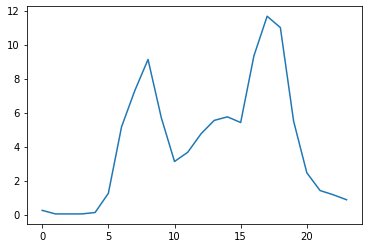

In [79]:
plt.plot(np.mean(lag_0[:,69].reshape(24,24), axis = 0)) # 6-10 am and 4-8 pm

#### Variable: Time + Weather

In [80]:
# select those data in the mornning and evening rush hours
index_hour = []
for i in range (24): # 24days
    index_hour.append(np.arange(6,10) + 24*i)
    index_hour.append(np.arange(16,20) + 24*i)
index_hour = np.array(index_hour).flatten()
index_rush = []
for i in index_hour:
    index_rush.append(np.arange(i*100, (i+1)*100))
index_rush = np.array(index_rush).flatten()

# array form into dataframe
# OLS (coef estimates)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_72', 
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
print(len(y))
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

19200
                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3075.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:48:20   Log-Likelihood:                -46535.
No. Observations:               19200   AIC:                         9.310e+04
Df Residuals:                   19186   BIC:                         9.321e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3884    

In [81]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 7.425388479893615
Testing MSE: 7.607761301845658
Training r^2: 0.6802442419111081
Testing r^2: 0.6561501592211716

XGBoost:
Training MSE: 4.262545031361698
Testing MSE: 5.445830157239366
Training r^2: 0.8164441737180832
Testing r^2: 0.7538634878014622

MLP:
Training MSE: 5.172937370488141
Testing MSE: 6.002949413374234
Training r^2: 0.7772404077004611
Testing r^2: 0.7286832330699791



#### Variable: Time + Space + Weather

In [82]:
# OLS (coef)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     3345.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:48:30   Log-Likelihood:                -45483.
No. Observations:               19200   AIC:                         9.100e+04
Df Residuals:                   19185   BIC:                         9.111e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3132      0.52

In [83]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=10)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.796077370172187
Testing MSE: 6.254870383005161
Training r^2: 0.7033455419967216
Testing r^2: 0.7324326765089404

XGBoost:
Training MSE: 4.160465820949644
Testing MSE: 4.963599821948001
Training r^2: 0.8183921892102134
Testing r^2: 0.7876699215306135

MLP:
Training MSE: 4.8720000371459955
Testing MSE: 4.980270939198525
Training r^2: 0.7873331259065877
Testing r^2: 0.7869567738634056



#### Variable: Time + Space + Weather + graph

In [84]:
# OLS (time + spatial + weather + graph)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     1486.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:48:40   Log-Likelihood:                -45370.
No. Observations:               19200   AIC:                         9.081e+04
Df Residuals:                   19167   BIC:                         9.107e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3529      0.52

In [85]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.565623901320086
Testing MSE: 6.7878057287923435
Training r^2: 0.7172678502171471
Testing r^2: 0.6932098909942618

XGBoost:
Training MSE: 4.016604508497538
Testing MSE: 5.463782044987945
Training r^2: 0.8270349863800941
Testing r^2: 0.7530521119578837

MLP:
Training MSE: 4.556166891922086
Testing MSE: 5.661476638010895
Training r^2: 0.803800083665531
Testing r^2: 0.7441168612794371



#### Variable: Time + Space + Weather + transit

In [86]:
# OLS (time + spatial + weather + public transit)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     2764.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:48:50   Log-Likelihood:                -45458.
No. Observations:               19200   AIC:                         9.095e+04
Df Residuals:                   19182   BIC:                         9.109e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3261      0.51

In [87]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.628885846038374
Testing MSE: 6.836624937272032
Training r^2: 0.7145436330066472
Testing r^2: 0.6910033973364472

XGBoost:
Training MSE: 3.9552452247698833
Testing MSE: 5.192473341939983
Training r^2: 0.8296772702602244
Testing r^2: 0.7653145174992249

MLP:
Training MSE: 5.0066859060099205
Testing MSE: 5.849115971464431
Training r^2: 0.7843996106433869
Testing r^2: 0.735636080617169



#### Variable: Time + Space + Weather + graph + transit

In [88]:
# OLS (all features)

var_list = ['lag_24', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'gw_lag_0', 'lag_72',
            'degree_24', 'pagerank_24', 'betweenness_24', 'degree_72', 'pagerank_72', 'betweenness_72',
            'degree_96', 'pagerank_96', 'betweenness_96', 'degree_120', 'pagerank_120', 'betweenness_120',
            'degree_144', 'pagerank_144', 'betweenness_144', 'degree_168', 'pagerank_168', 'betweenness_168',
            'metro_dnum_0', 'bus_dnum_0', 'bus_snum_0',
            'visibility', 'temperature', 'dew_point_temp', 'relative_humidity', 'wind_speed', 'wind_direction', 'precipitation']

y = bike_tripfactor_data['lag_0'].iloc[index_rush]
X = bike_tripfactor_data[var_list].iloc[index_rush, :]

x = sm.add_constant(X)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lag_0   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     1364.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        22:49:00   Log-Likelihood:                -45344.
No. Observations:               19200   AIC:                         9.076e+04
Df Residuals:                   19164   BIC:                         9.104e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3782      0.52

In [89]:
### training and testing performance
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=9)

## OLS: Linear regression in the training and testing set
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)
print("OLS:")
mse_train = mean_squared_error(y_train, linearModel.predict(X_train))
mse_test = mean_squared_error(y_test, linearModel.predict(X_test))
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, linearModel.predict(X_train))
r2_test = r2_score(y_test, linearModel.predict(X_test))
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## XGBoost models
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('XGBoost:')
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")


## MLP - Neural Networks
model = Sequential()
model.add(Dense(len(var_list), input_dim=len(var_list), activation='relu'))
model.add(Dense(20, activation='relu')) # Add a hidden layer with 20 neurons and ReLU activation
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("MLP:")
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Training r^2:", r2_train)
print("Testing r^2:", r2_test)

print('='*50)
print("")

OLS:
Training MSE: 6.5475903461378895
Testing MSE: 6.771370417791862
Training r^2: 0.7180444201062425
Testing r^2: 0.6939527217491246

XGBoost:
Training MSE: 3.9307745364873776
Testing MSE: 5.302249894181856
Training r^2: 0.8307310391645608
Testing r^2: 0.760352919926433

MLP:
Training MSE: 4.358990894985635
Testing MSE: 5.3507240508908
Training r^2: 0.8122909741486444
Testing r^2: 0.758162021657554



### Baseline Model

#### Hourly average with all, non-zero, rush-hour dataset 

In [91]:
# Hourly average (all data)
station_average_hourly = []
for i in range (lag_0.shape[1]):
    station_average_hourly.append(np.array(list(np.mean(lag_0[:, i].reshape((24,24)), axis = 1)) * 24))
station_average_hourly = np.array(station_average_hourly).T
print("HA MSE:", mean_squared_error(station_average_hourly.flatten(), lag_0.flatten()))
print("HA r_2:", r2_score(station_average_hourly.flatten(), lag_0.flatten()))

HA MSE: 15.568816550925927
HA r_2: -2.9261303470023172


In [92]:
# Hourly average (non-zero data)
lag_0_index = lag_0.copy()
station_average_hourly = []
for i in range (lag_0_index.shape[1]):
    for j in range (lag_0_index.shape[0]):
        if lag_0_index[j, i] == 0:
            lag_0_index[j, i] = np.nan
    station_average_hourly.append(np.array(list(np.nanmean(lag_0_index[:, i].reshape((24,24)), axis = 1)) * 24))
station_average_hourly = np.array(station_average_hourly).T.flatten()
lag_0_index = lag_0_index.flatten()
index_nonnan = []
for i in range (len(station_average_hourly)):
    if ~np.isnan(station_average_hourly[i]) and ~np.isnan(lag_0_index[i]):
        index_nonnan.append(i)
index_nonnan = np.array(index_nonnan)
print("HA MSE:", mean_squared_error(station_average_hourly[index_nonnan], lag_0_index[index_nonnan]))
print("HA r_2:", r2_score(station_average_hourly[index_nonnan], lag_0_index[index_nonnan]))

HA MSE: 24.788846107916992
HA r_2: -5.2179335332675185


In [93]:
# Hourly average (rush-hour data)
station_average_hourly = []
for i in range (lag_0.shape[1]):
    station_average_hourly.append(np.array(list(np.mean(lag_0[index_hour, i].reshape((8,24)), axis = 1)) * 24))
station_average_hourly = np.array(station_average_hourly).T
print("HA MSE:", mean_squared_error(station_average_hourly.flatten(), lag_0[index_hour, :].flatten()))
print("HA r_2:", r2_score(station_average_hourly.flatten(), lag_0[index_hour, :].flatten()))

HA MSE: 29.272903645833335
HA r_2: -1.6413825567065614


#### Hourly average with all dataset

In [94]:
# ARIMA (all data)
arma_pred = []
for i in range (lag_0.shape[1]):
    data = lag_0[:, i]
    model = ARIMA(data, order=(6, 1, 1))  # Use an ARMA(6, 1) model
    result = model.fit()
    preds = result.predict(1, lag_0.shape[0])
    arma_pred.append(preds)
arma_pred = np.array(arma_pred).flatten()
print("ARMA MSE:", mean_squared_error(lag_0.flatten(), arma_pred))
print("ARMA r^2:",r2_score(lag_0.flatten(), arma_pred))

ARMA MSE: 19.96875492908718
ARMA r^2: -0.5764350980239119
